# Best model results

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from thesis_project.data_loading import load_session_ids
from thesis_project.settings import EXPERIMENT1_DIR
import pandas as pd
from thesis_project.training.best_model_retraining import OUTPUT_DIR
from thesis_project.evaluation.retrained_model_visualizations import (
    calculate_visualization_data,
)
from thesis_project.evaluation.confusion_matrix import plot_confusion_matrix
from thesis_project.evaluation.permutation_importance import plot_permutation_importance
import pickle
from thesis_project.settings import RESULT_DIR
from thesis_project.data_loading import load_train_test_ids
from thesis_project.preprocessing.label_preparation import get_label_dict
from thesis_project.data_loading import TARGET_WORDS, SEMANTIC_CAT, SYNTACTIC_CAT
import json
from thesis_project.data_loading import TARGET_WORDS
from thesis_project.preprocessing.german_to_english import GERMAN_TO_ENGLISH_DICT
from thesis_project.settings import DATA_DIR
import seaborn as sns
from matplotlib import pyplot as plt

from thesis_project.settings import FIGURE_DIR
from matplotlib.patches import Patch
import numpy as np

from thesis_project.evaluation.permutation_importance import (
    BRAIN_COLOR_DICT,
    get_permutation_importance_metadata,
)
from thesis_project.evaluation.hyperparameter_plots import MODEL_PREFIX_TO_NAME_DICT

from thesis_project.data_loading import pickle_object, unpickle_object
import os
from pathlib import Path

## Retrained model tables

In [3]:
def create_combined_results_table(results,
                                  metric_name,
                                  label_names):

    session_ids = sorted(load_session_ids(EXPERIMENT1_DIR))
    result_dict = {label_name: {"session_id": [], **{model_name: [] for model_name in results.keys()}} for label_name in label_names}

    for label_name in result_dict.keys():
        for session_id in session_ids:
            result_dict[label_name]["session_id"].append(session_id)
            for model_name, df in results.items():
                current_row = df[(df['session_id'] == int(session_id)) & (df["label_name"] == label_name)]
                result_dict[label_name][model_name].append(current_row[metric_name].item())

    return result_dict


### Classification accuracy

In [5]:
results = {}
for model_name in ["svm", "rnn", "trf"]:
    results[model_name] = pd.read_csv(f"{OUTPUT_DIR}/svm_clf/results.csv")

In [6]:
label_names = ["syncat_labels", "semcat_labels", "labels_words"]
result_dict = create_combined_results_table(results, "test_accuracy", label_names)

In [7]:
model_names = ["svm", "rnn", "trf"]
combined_df = {"session_id": []}
combined_df = {**combined_df, **{f"{label_name}_{model_name}": [] for model_name in model_names for label_name in label_names}}
combined_df["session_id"] = []
session_ids = load_session_ids(EXPERIMENT1_DIR)

label_names = ["syncat_labels", "semcat_labels", "labels_words"]

for i, session_id in enumerate(session_ids):

    combined_df["session_id"].append(session_id)

    for label_name in label_names:

            for model_name in model_names:
                combined_df[f"{label_name}_{model_name}"].append(result_dict[label_name][model_name][i])

In [13]:
pd.DataFrame(combined_df)

session_id  syncat_labels_svm  semcat_labels_svm  labels_words_svm  \
0   20221117           0.909091            0.69697          0.303030   
1   20221121           0.781250            0.68750          0.468750   
2   20221114           0.750000            0.53125          0.343750   
3   20221109           0.750000            0.59375          0.468750   
4   20221123           0.687500            0.53125          0.343750   
5   20221116           0.588235            0.50000          0.352941   

   syncat_labels_rnn  semcat_labels_rnn  labels_words_rnn  syncat_labels_trf  \
0           0.909091            0.69697          0.303030           0.909091   
1           0.781250            0.68750          0.468750           0.781250   
2           0.750000            0.53125          0.343750           0.750000   
3           0.750000            0.59375          0.468750           0.750000   
4           0.687500            0.53125          0.343750           0.687500   
5           0.588235            0.50000          0.352941           0.588235   

   semcat_labels_trf  labels_words_trf  
0            0.69697          0.303030  
1            0.68750          0.468750  
2            0.53125          0.343750  
3            0.59375          0.468750  
4            0.53125          0.343750  
5            0.50000          0.352941

### Regression MSE

In [14]:
results = {}
for model_name in ["svm", "rnn", "trf"]:
    results[model_name] = pd.read_csv(f"{OUTPUT_DIR}/{model_name}_reg/results.csv")

In [15]:
result_dict = create_combined_results_table(results, "train_mse", ["labels_words"])
pd.DataFrame(result_dict["labels_words"])

session_id       svm       rnn       trf
0   20221109  0.026190  0.683303  0.128592
1   20221114  0.027488  0.689039  0.171160
2   20221116  0.023128  0.725569  0.139325
3   20221117  0.044076  0.591436  0.064594
4   20221121  0.034152  0.707884  0.160569
5   20221123  0.037531  0.771265  0.226579

In [16]:
result_dict = create_combined_results_table(results, "test_mse", ["labels_words"])
pd.DataFrame(result_dict["labels_words"])

session_id       svm       rnn       trf
0   20221109  0.267263  0.730720  0.274801
1   20221114  0.209515  0.747361  0.228982
2   20221116  0.207529  0.792885  0.197418
3   20221117  0.254949  0.711368  0.235398
4   20221121  0.309787  0.821154  0.308175
5   20221123  0.309130  0.867294  0.329233

### Regression decoding accuracy

In [18]:
results = {}

for model_name in ["svm", "rnn", "trf"]:
    results[model_name] = calculate_visualization_data(model_name, "reg", label_names=["labels_words"], visualization_options=["accuracy"])

100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


In [59]:
import torch


session_ids = load_session_ids(EXPERIMENT1_DIR)
output_type = "test"
metric_name = "test_accuracy"
label_name = "labels_words"
nonstrict_result_dict = {"session_id": [], **{model_name: [] for model_name in results.keys()}}
strict_result_dict = {"session_id": [], **{model_name: [] for model_name in results.keys()}}


for session_id in session_ids:
    nonstrict_result_dict["session_id"].append(session_id)
    strict_result_dict["session_id"].append(session_id)

    for model_name, model_results in results.items():
        
        nonstrict_result = model_results.nonstrict_accuracies[label_name][output_type][session_id]
        strict_result = model_results.strict_accuracies[label_name][output_type][session_id]

        if isinstance(nonstrict_result, torch.Tensor):
            nonstrict_result = nonstrict_result.item()

        if isinstance(strict_result, torch.Tensor):
            strict_result = strict_result.item()

        nonstrict_result_dict[model_name].append(nonstrict_result)
        strict_result_dict[model_name].append(strict_result)



In [60]:
pd.DataFrame(nonstrict_result_dict)

session_id       svm       rnn       trf
0   20221117  0.218750  0.031250  0.187500
1   20221121  0.062500  0.093750  0.062500
2   20221114  0.281250  0.031250  0.218750
3   20221109  0.151515  0.060606  0.303030
4   20221123  0.147059  0.058824  0.205882
5   20221116  0.156250  0.093750  0.156250

In [61]:
pd.DataFrame(strict_result_dict)

session_id       svm       rnn       trf
0   20221117  0.281250  0.281250  0.218750
1   20221121  0.250000  0.375000  0.218750
2   20221114  0.343750  0.375000  0.250000
3   20221109  0.272727  0.303030  0.333333
4   20221123  0.176471  0.088235  0.264706
5   20221116  0.187500  0.218750  0.250000

### Regression decoding results

In [23]:
print("Format: (expected, predicted)\n")
for session_id, prediction in results["svm"].nonstrict_predictions["labels_words"]["test"].items():
    print(session_id)
    for p in prediction:
        print(p)
    print()

Format: (expected, predicted)

20221117
('door', 'fish')
('clean', 'clean')
('deer', 'fish')
('swipe', 'fish')
('hall', 'fish')
('milk', 'fish')
('swipe', 'clean')
('whale', 'horse')
('door', 'clean')
('swipe', 'clean')
('fish', 'fish')
('fish', 'fish')
('clean', 'fish')
('deer', 'horse')
('clean', 'fish')
('hall', 'house')
('whale', 'horse')
('door', 'hand')
('fish', 'fish')
('clean', 'fish')
('door', 'clean')
('milk', 'milk')
('fish', 'fish')
('deer', 'horse')
('swipe', 'clean')
('hall', 'horse')
('milk', 'fish')
('whale', 'deer')
('whale', 'fish')
('hall', 'deer')
('milk', 'milk')
('deer', 'fish')

20221121
('cattle', 'deer')
('shark', 'head')
('eat', 'pull')
('pull', 'clean')
('arm', 'arm')
('knee', 'clean')
('avoid', 'pull')
('knee', 'clean')
('rub', 'clean')
('eat', 'clean')
('rub', 'fish')
('pull', 'clean')
('rub', 'horse')
('cattle', 'head')
('eat', 'clean')
('knee', 'knee')
('shark', 'clean')
('avoid', 'head')
('shark', 'avoid')
('arm', 'clean')
('avoid', 'horse')
('eat', 'cle

In [24]:
print("Format: (expected, predicted)\n")
for session_id, prediction in results["rnn"].nonstrict_predictions["labels_words"]["test"].items():
    print(session_id)
    for p in prediction:
        print(p)
    print()

Format: (expected, predicted)

20221117
('door', 'sprain')
('clean', 'tick')
('deer', 'whale')
('swipe', 'shark')
('hall', 'shark')
('milk', 'rooster')
('swipe', 'tick')
('whale', 'sprain')
('door', 'rooster')
('swipe', 'tick')
('fish', 'shark')
('fish', 'whale')
('clean', 'shark')
('deer', 'roach')
('clean', 'whale')
('hall', 'shift')
('whale', 'hall')
('door', 'rooster')
('fish', 'whale')
('clean', 'whale')
('door', 'rooster')
('milk', 'whale')
('fish', 'rooster')
('deer', 'whale')
('swipe', 'tick')
('hall', 'shark')
('milk', 'whale')
('whale', 'shark')
('whale', 'whale')
('hall', 'roach')
('milk', 'tick')
('deer', 'goat')

20221121
('cattle', 'cattle')
('shark', 'shark')
('eat', 'tick')
('pull', 'wipe')
('arm', 'sprain')
('knee', 'sprain')
('avoid', 'pigeon')
('knee', 'roach')
('rub', 'wipe')
('eat', 'wipe')
('rub', 'whale')
('pull', 'pigeon')
('rub', 'shark')
('cattle', 'calf')
('eat', 'fish')
('knee', 'sprain')
('shark', 'shark')
('avoid', 'wipe')
('shark', 'tick')
('arm', 'mouth'

In [25]:
print("Format: (expected, predicted)\n")
for session_id, prediction in results["trf"].nonstrict_predictions["labels_words"]["test"].items():
    print(session_id)
    for p in prediction:
        print(p)
    print()

Format: (expected, predicted)

20221117
('door', 'fish')
('clean', 'fish')
('deer', 'fish')
('swipe', 'milk')
('hall', 'fish')
('milk', 'clean')
('swipe', 'hunt')
('whale', 'fish')
('door', 'wipe')
('swipe', 'horse')
('fish', 'fish')
('fish', 'fish')
('clean', 'horse')
('deer', 'horse')
('clean', 'clean')
('hall', 'house')
('whale', 'bear')
('door', 'door')
('fish', 'fish')
('clean', 'fish')
('door', 'hand')
('milk', 'milk')
('fish', 'clean')
('deer', 'fish')
('swipe', 'clean')
('hall', 'bear')
('milk', 'fish')
('whale', 'fish')
('whale', 'fish')
('hall', 'fish')
('milk', 'paint')
('deer', 'fish')

20221121
('cattle', 'fish')
('shark', 'head')
('eat', 'clean')
('pull', 'clean')
('arm', 'arm')
('knee', 'clean')
('avoid', 'clean')
('knee', 'clean')
('rub', 'clean')
('eat', 'clean')
('rub', 'deer')
('pull', 'head')
('rub', 'clean')
('cattle', 'arm')
('eat', 'rub')
('knee', 'knee')
('shark', 'head')
('avoid', 'clean')
('shark', 'fish')
('arm', 'clean')
('avoid', 'clean')
('eat', 'fish')
('

## Visualizations

In [4]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
svm_clf_visualization_dict = calculate_visualization_data(
    "svm",
    "clf",
    label_names=["syncat_labels", "semcat_labels", "labels_words"],
    visualization_options=["confusion_matrix", "permutation_importance"],
)
# rnn_clf_visualization_dict = calculate_visualization_data(
#     "rnn",
#     "clf",
#     label_names=["syncat_labels", "semcat_labels", "labels_words"],
#     visualization_options=["confusion_matrix", "permutation_importance"],
# )
# trf_clf_visualization_dict = calculate_visualization_data(
#     "trf",
#     "clf",
#     label_names=["syncat_labels", "semcat_labels", "labels_words"],
#     visualization_options=["confusion_matrix", "permutation_importance"],
# )

In [17]:
output_path = f"{RESULT_DIR}/final_results/retrained_models/trf_clf/rnn_clf_visualization_results.pkl"
#pickle_object(rnn_clf_visualization_dict, output_path)
rnn_clf_visualization_dict = unpickle_object(output_path)

In [18]:
output_path = f"{RESULT_DIR}/final_results/retrained_models/trf_clf/trf_clf_visualization_results.pkl"
#pickle_object(trf_clf_visualization_dict, output_path)
trf_clf_visualization_dict = unpickle_object(output_path)

In [ ]:
svm_reg_visualization_dict = calculate_visualization_data(
    "svm",
    "reg",
    label_names=["labels_words"],
    visualization_options=["confusion_matrix", "accuracy"],
)
rnn_reg_visualization_dict = calculate_visualization_data(
    "rnn",
    "reg",
    label_names=["labels_words"],
    visualization_options=["confusion_matrix", "accuracy"],
)
trf_reg_visualization_dict = calculate_visualization_data(
    "trf",
    "reg",
    label_names=["labels_words"],
    visualization_options=["confusion_matrix", "accuracy"],
)

### Confusion matrices

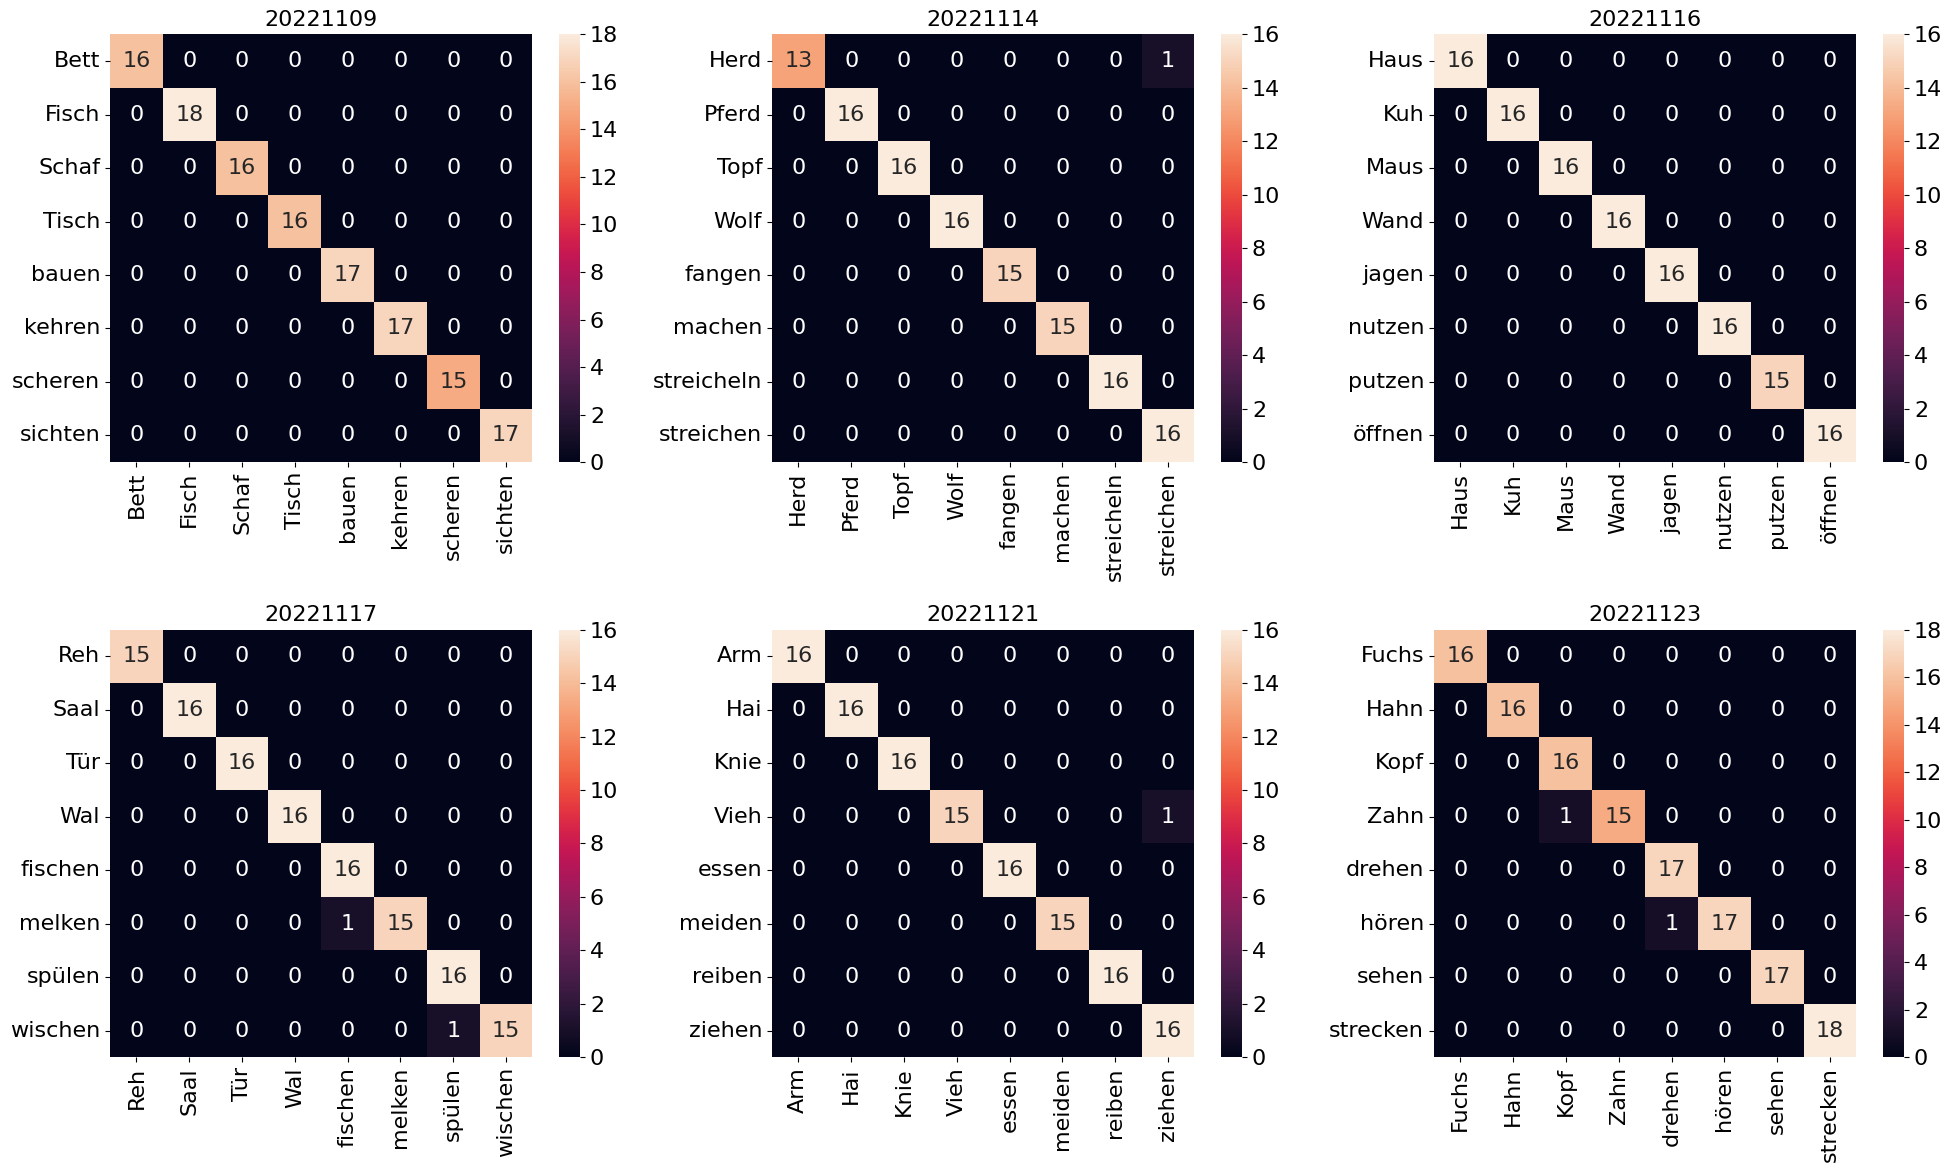

In [32]:
plot_confusion_matrix("svm", "clf", svm_reg_visualization_dict, label_name = "labels_words", input_type = "train")

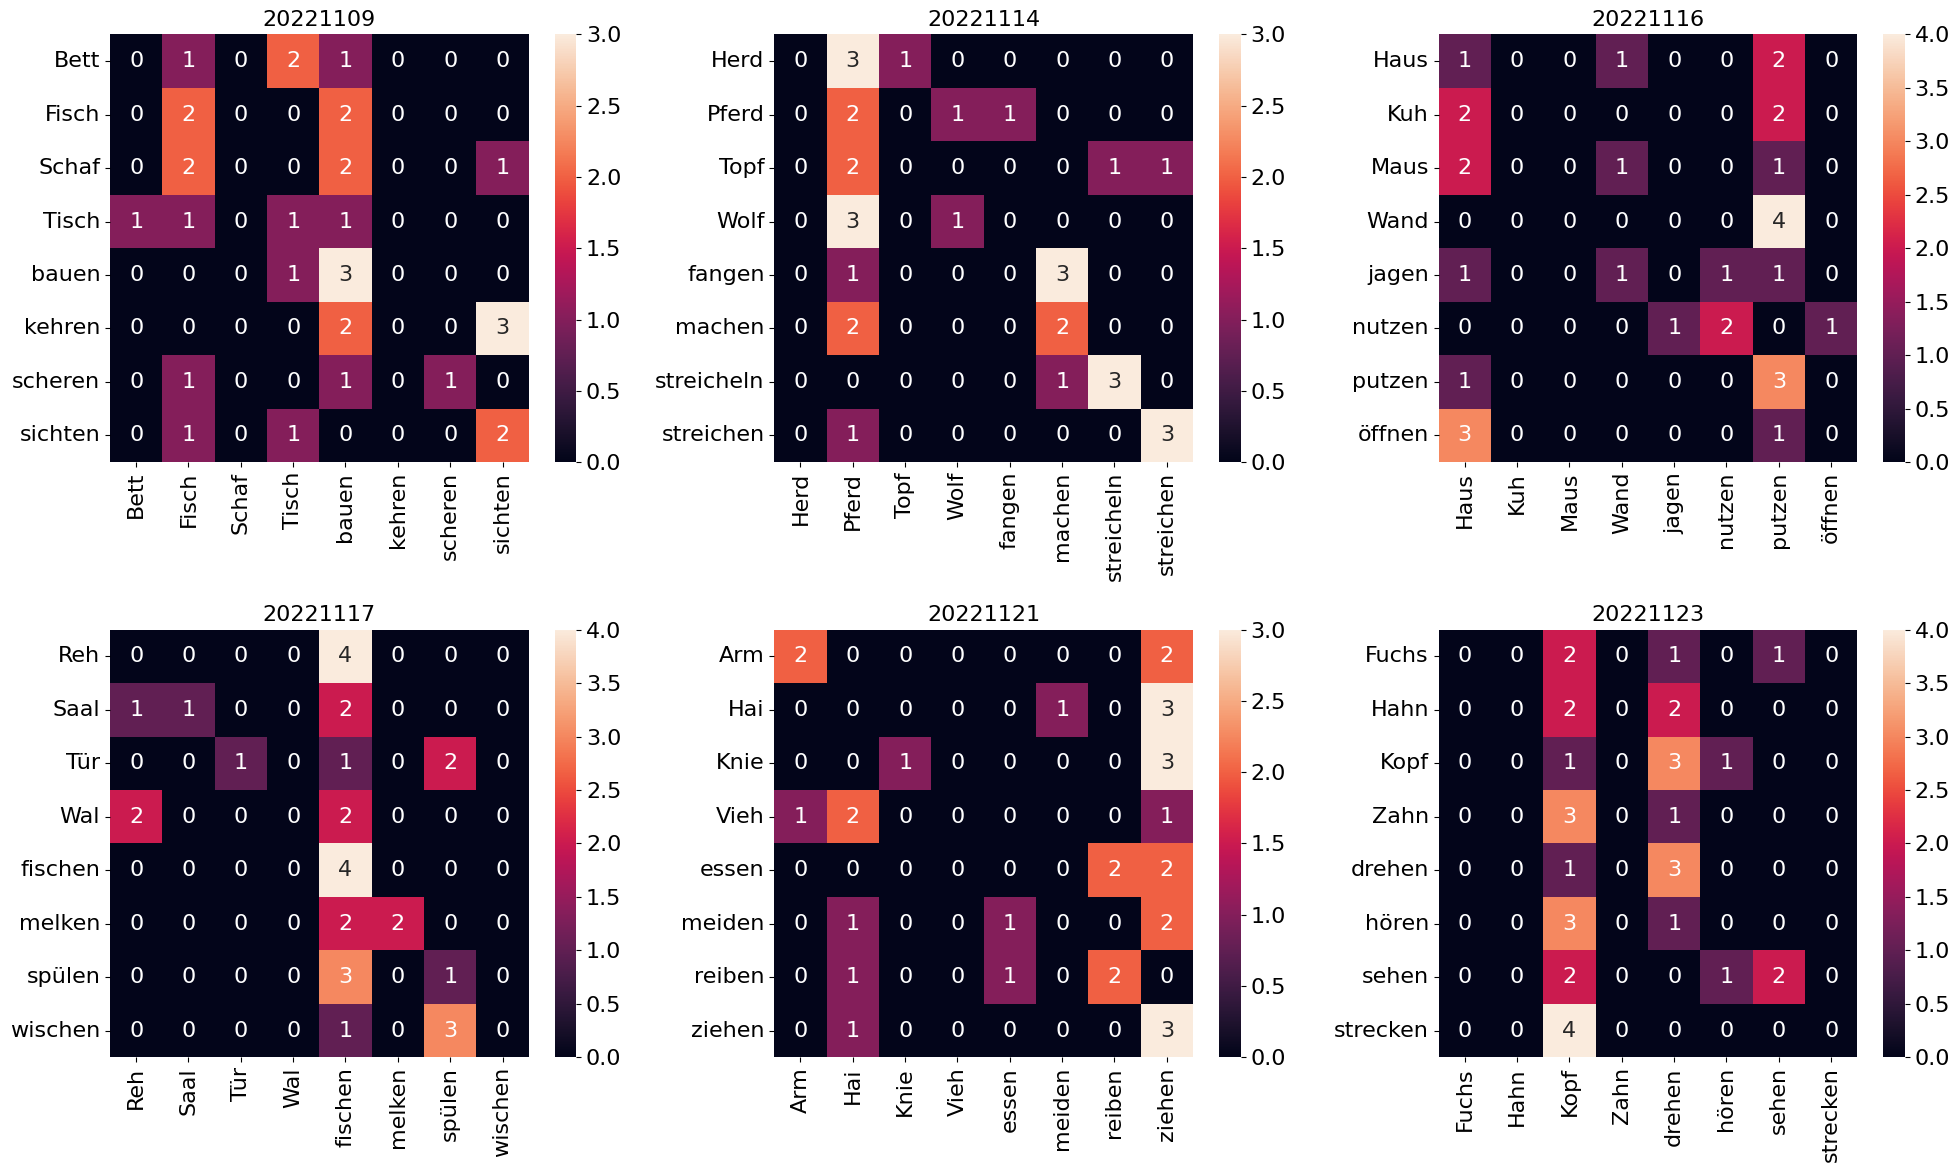

In [33]:
plot_confusion_matrix("svm", "clf", svm_reg_visualization_dict, label_name = "labels_words", input_type = "test")

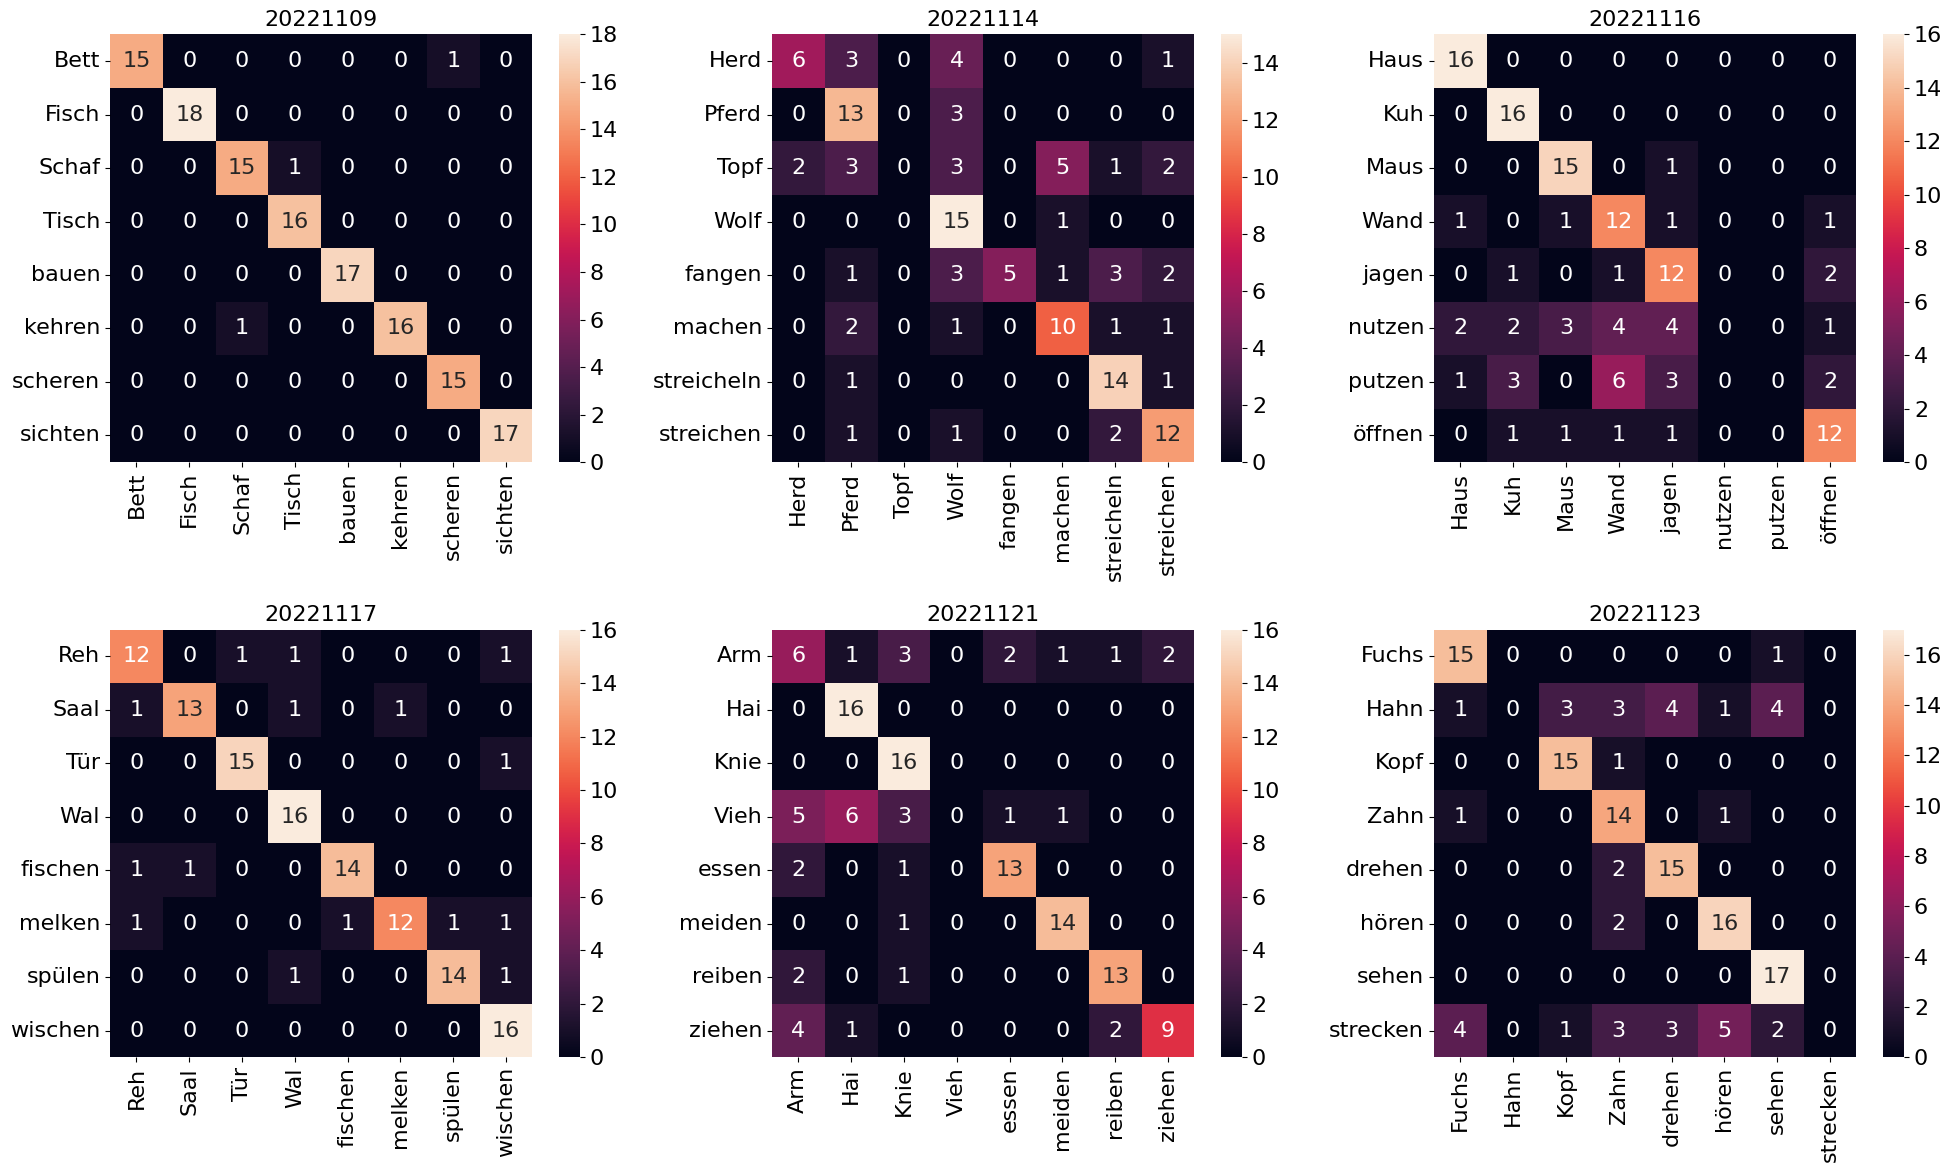

In [9]:
plot_confusion_matrix("rnn", "clf", rnn_clf_visualization_dict, label_name = "labels_words", input_type = "train")

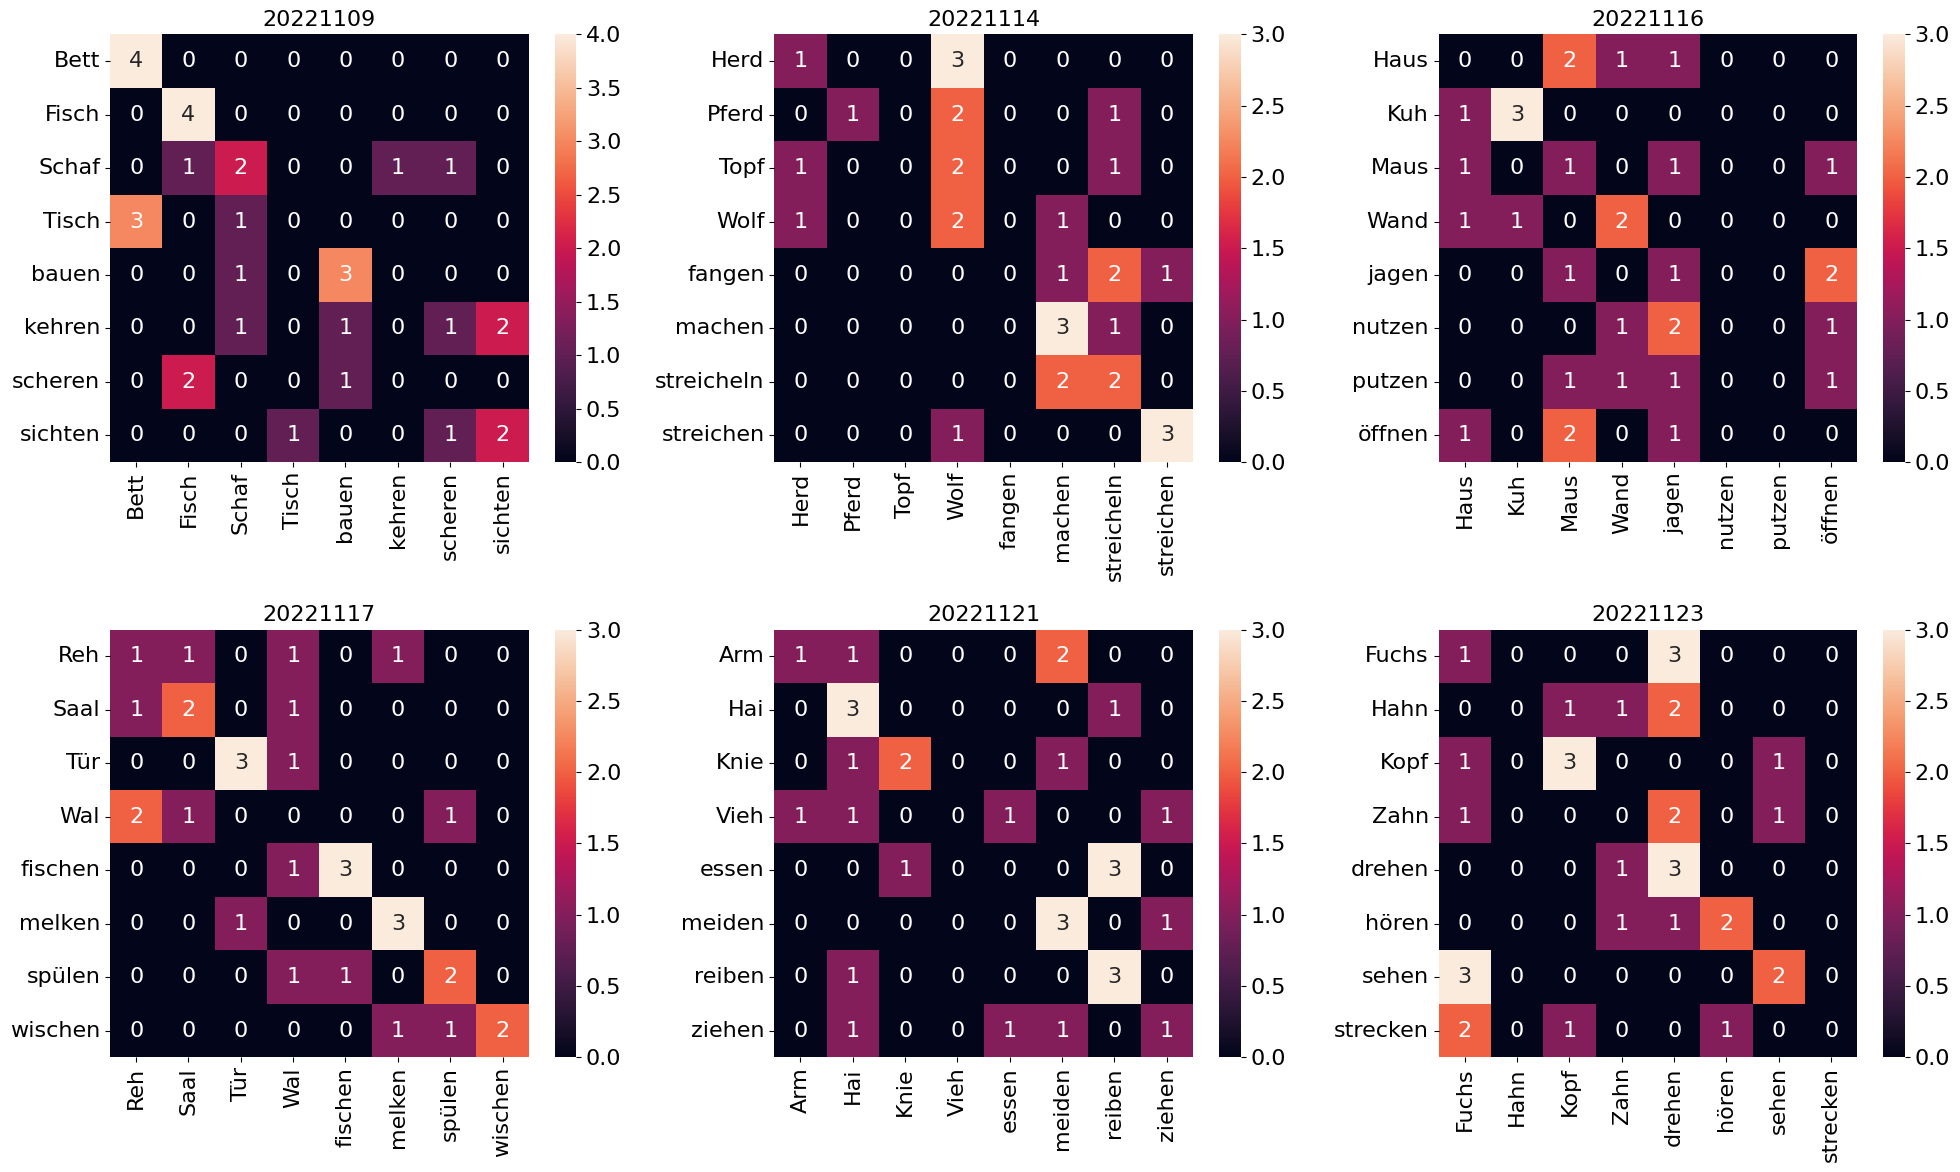

In [10]:
plot_confusion_matrix("rnn", "clf", rnn_clf_visualization_dict, label_name = "labels_words", input_type = "test")

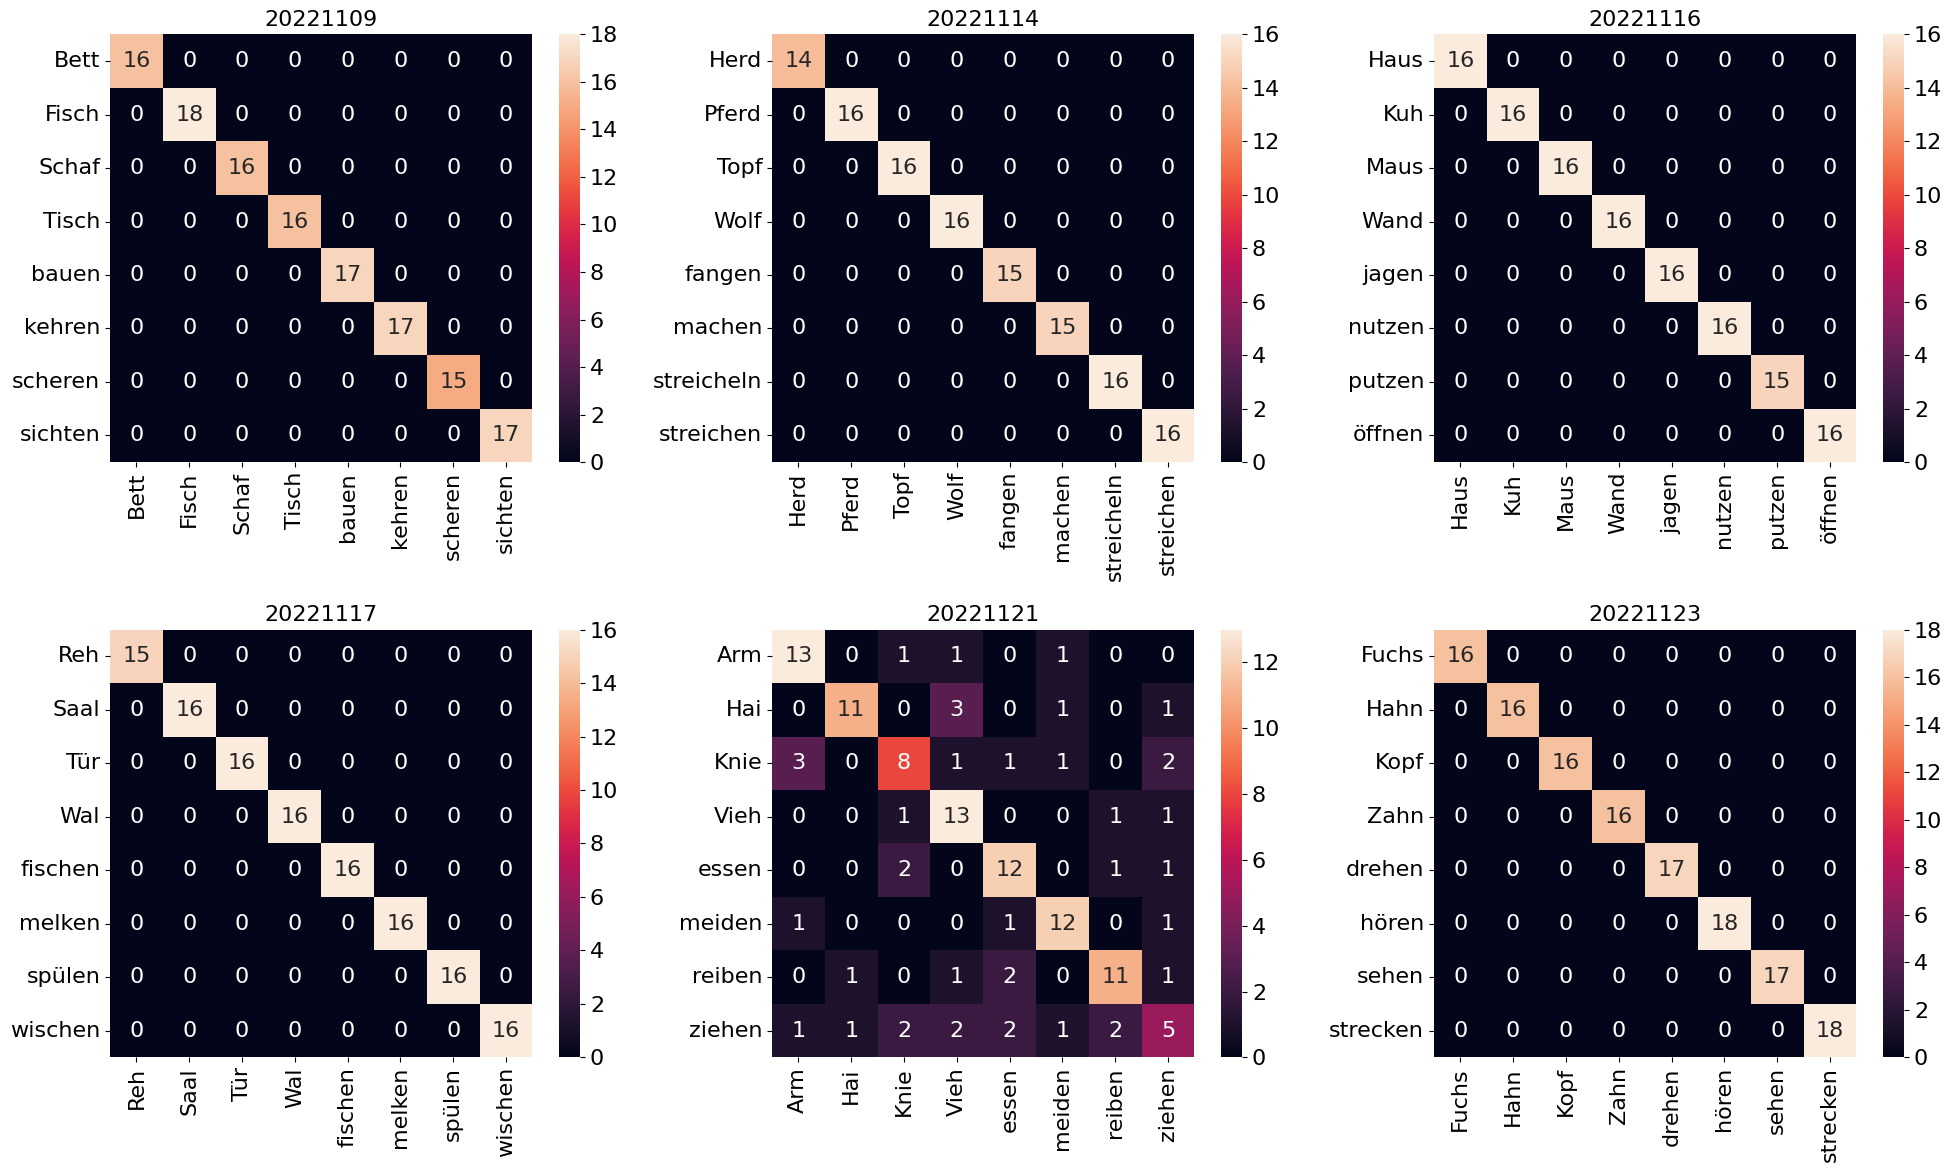

In [19]:
plot_confusion_matrix("trf", "clf", trf_clf_visualization_dict, label_name = "labels_words", input_type = "train")

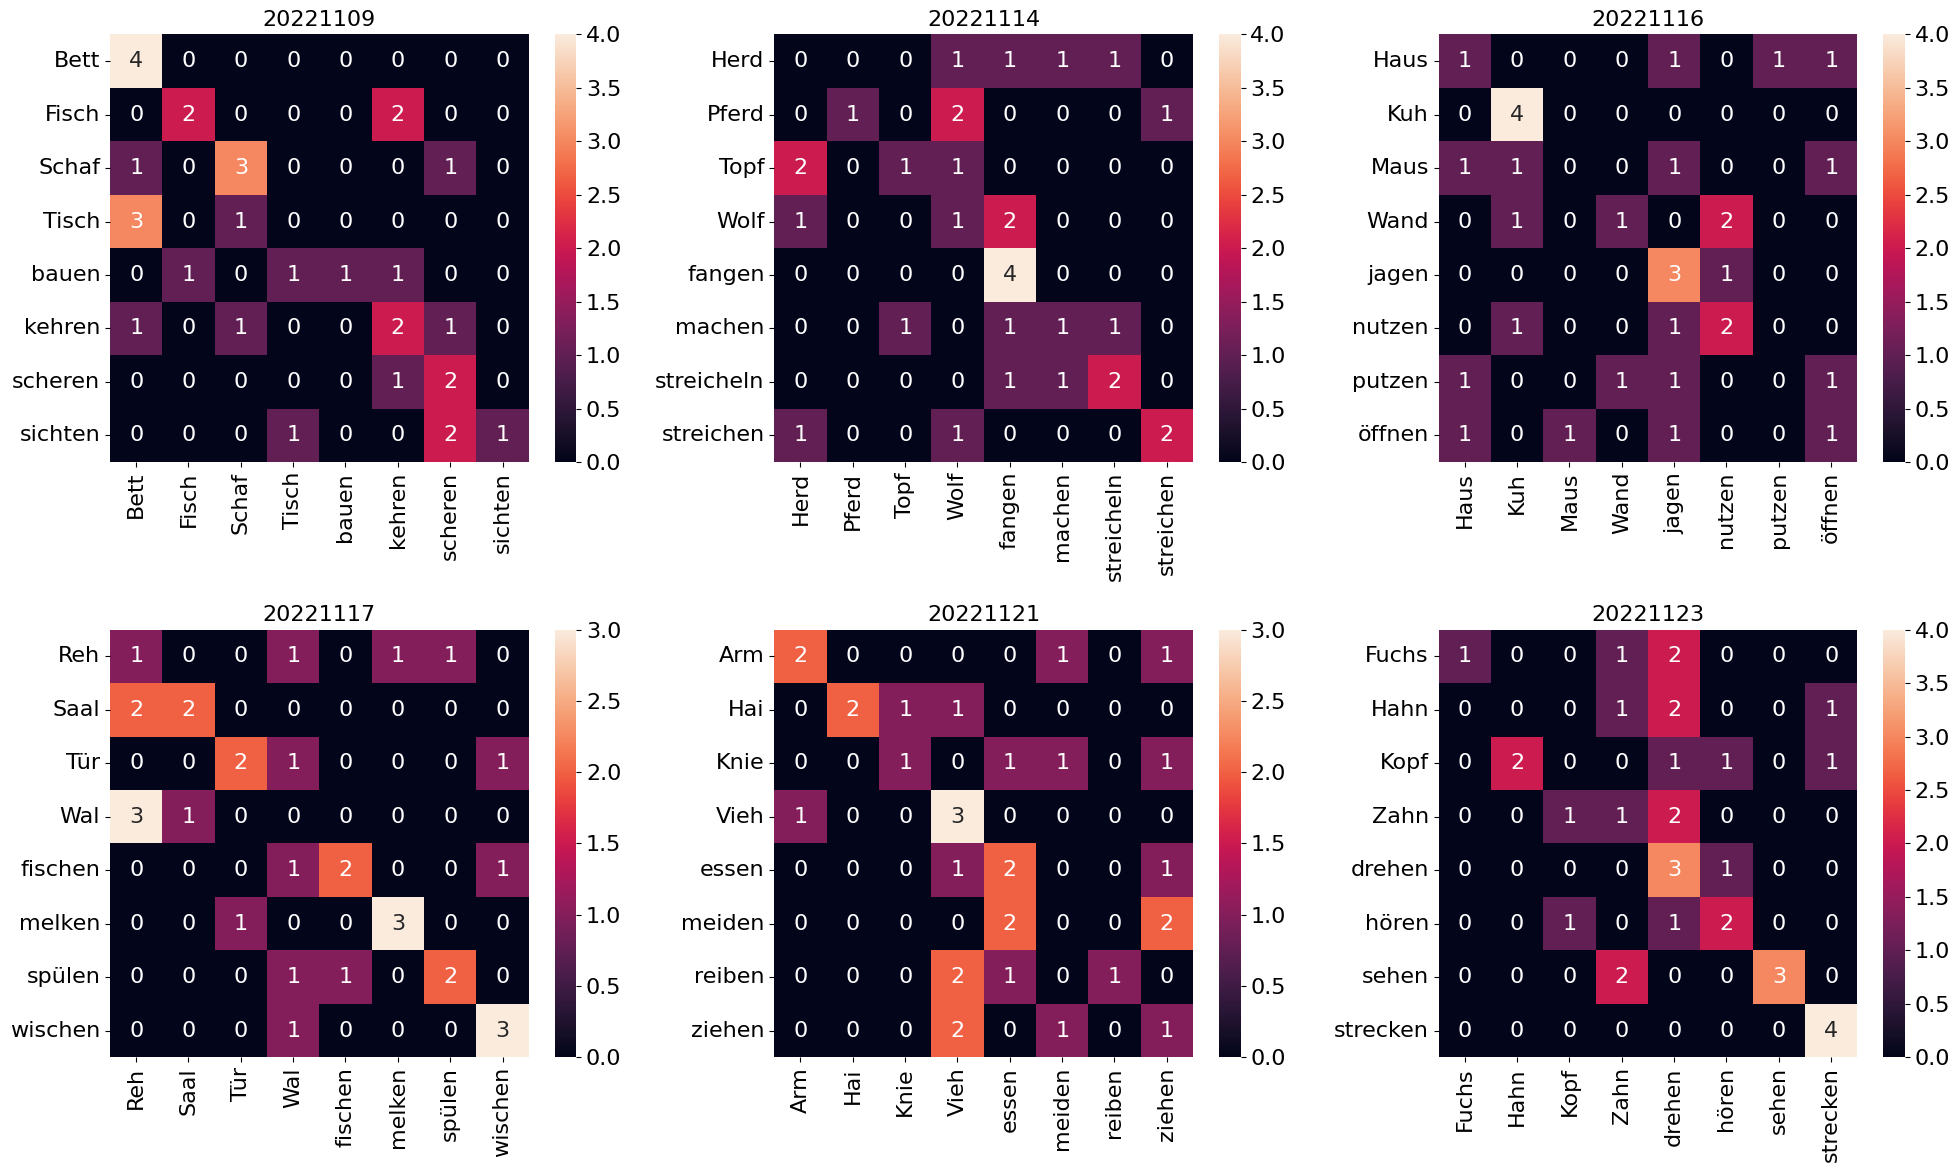

In [20]:
plot_confusion_matrix("trf", "clf", trf_clf_visualization_dict, label_name = "labels_words", input_type = "test")

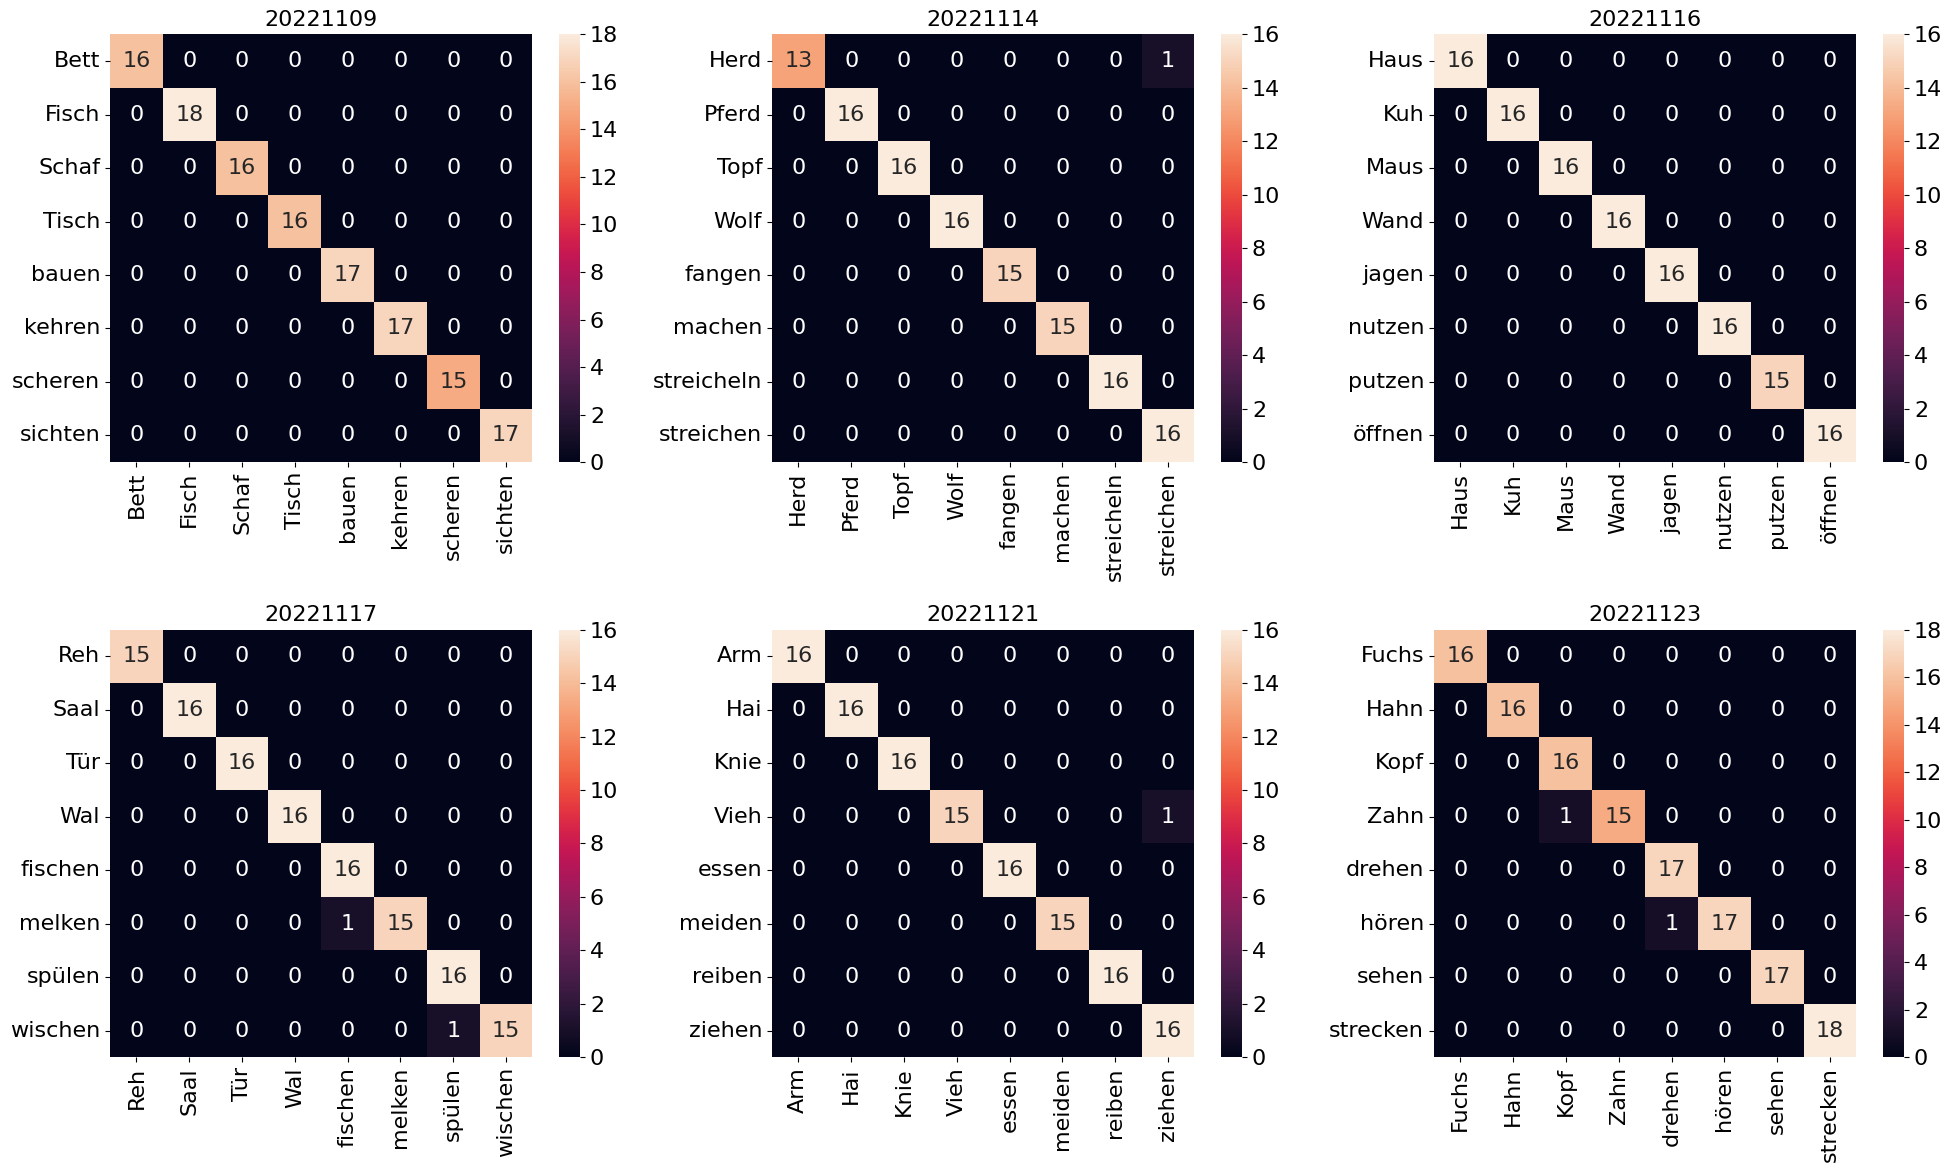

In [25]:
plot_confusion_matrix("svm", "reg", svm_reg_visualization_dict, label_name = "labels_words", input_type = "train")

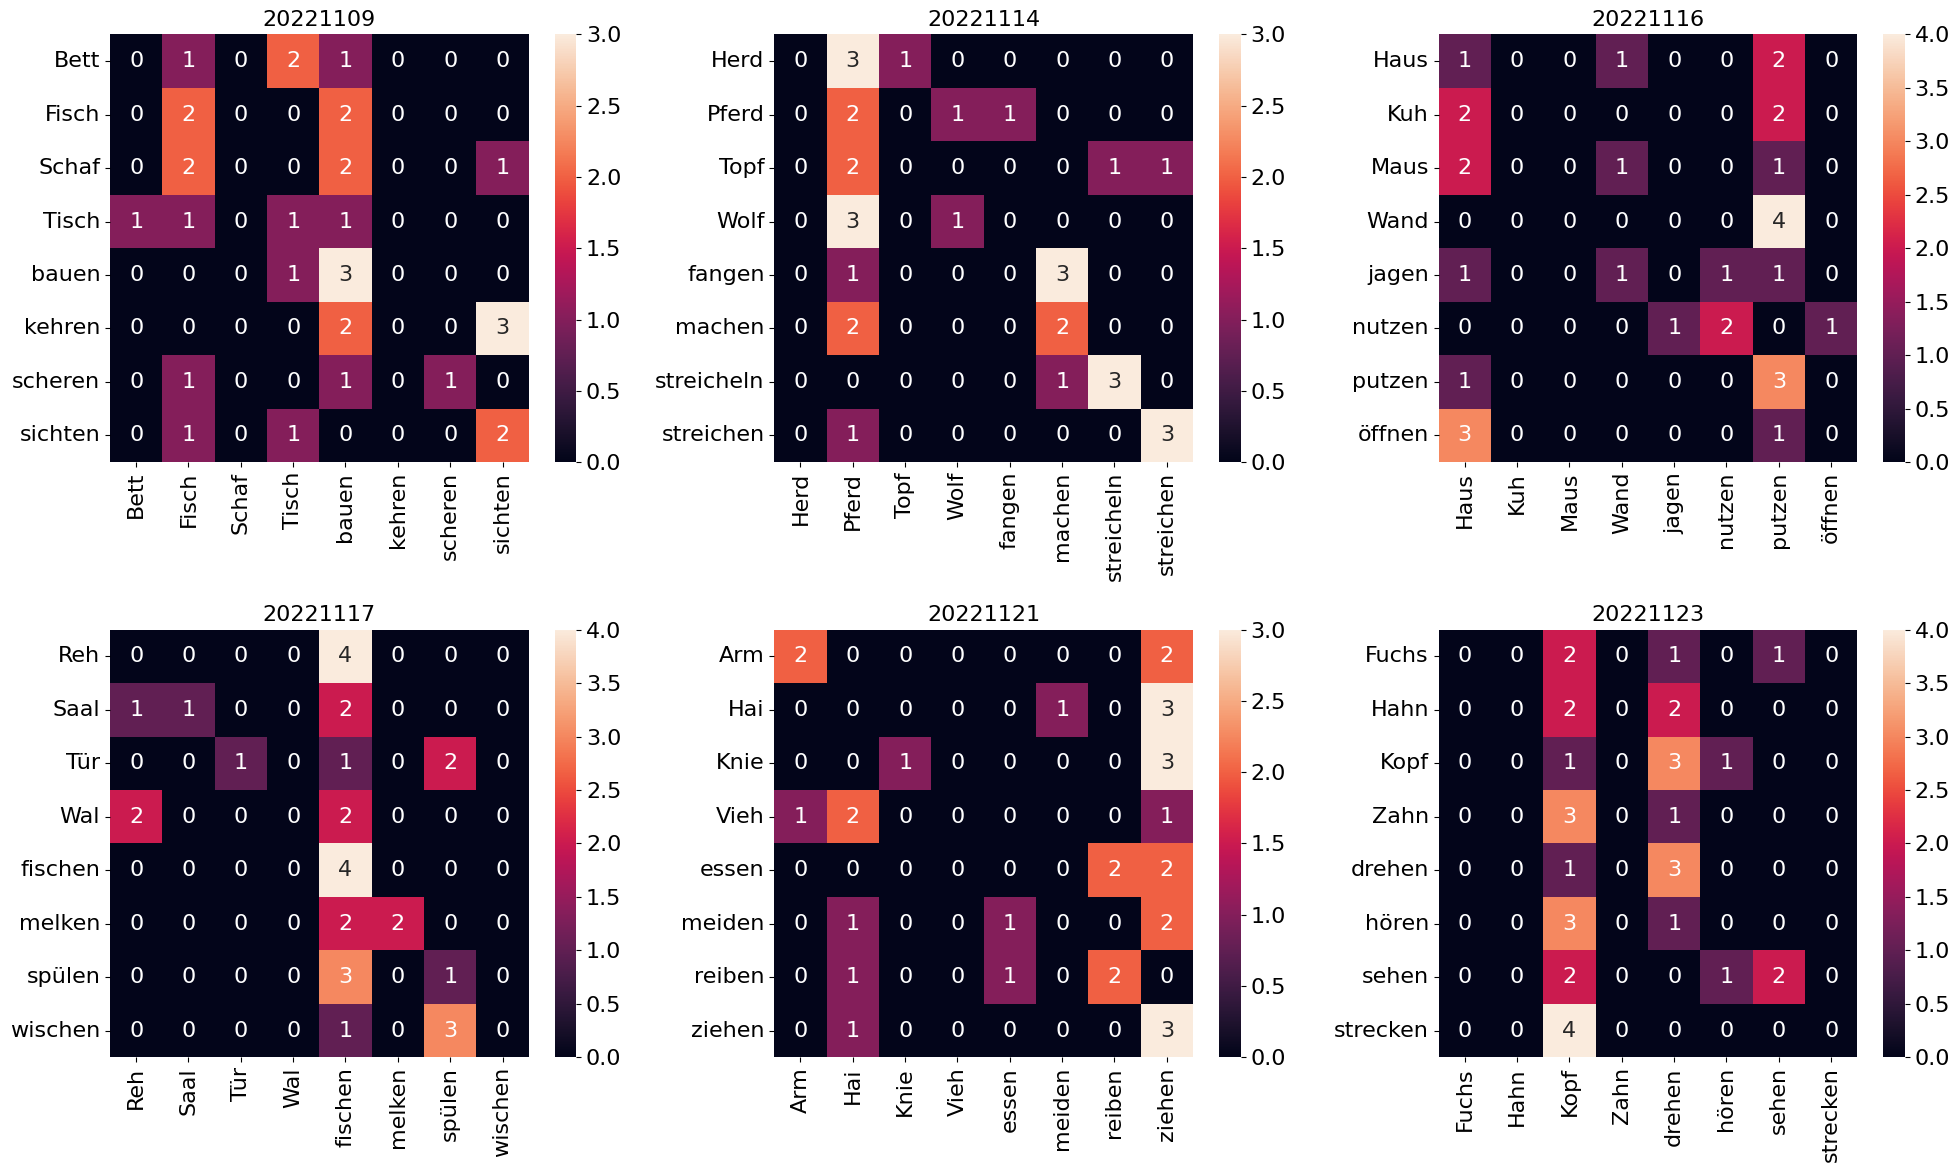

In [26]:
plot_confusion_matrix("svm", "reg", svm_reg_visualization_dict, label_name = "labels_words", input_type = "test")

In [6]:
plot_confusion_matrix("rnn", "reg", rnn_reg_visualization_dict, label_name = "labels_words", input_type = "train")

NameError: name 'rnn_reg_visualization_dict' is not defined

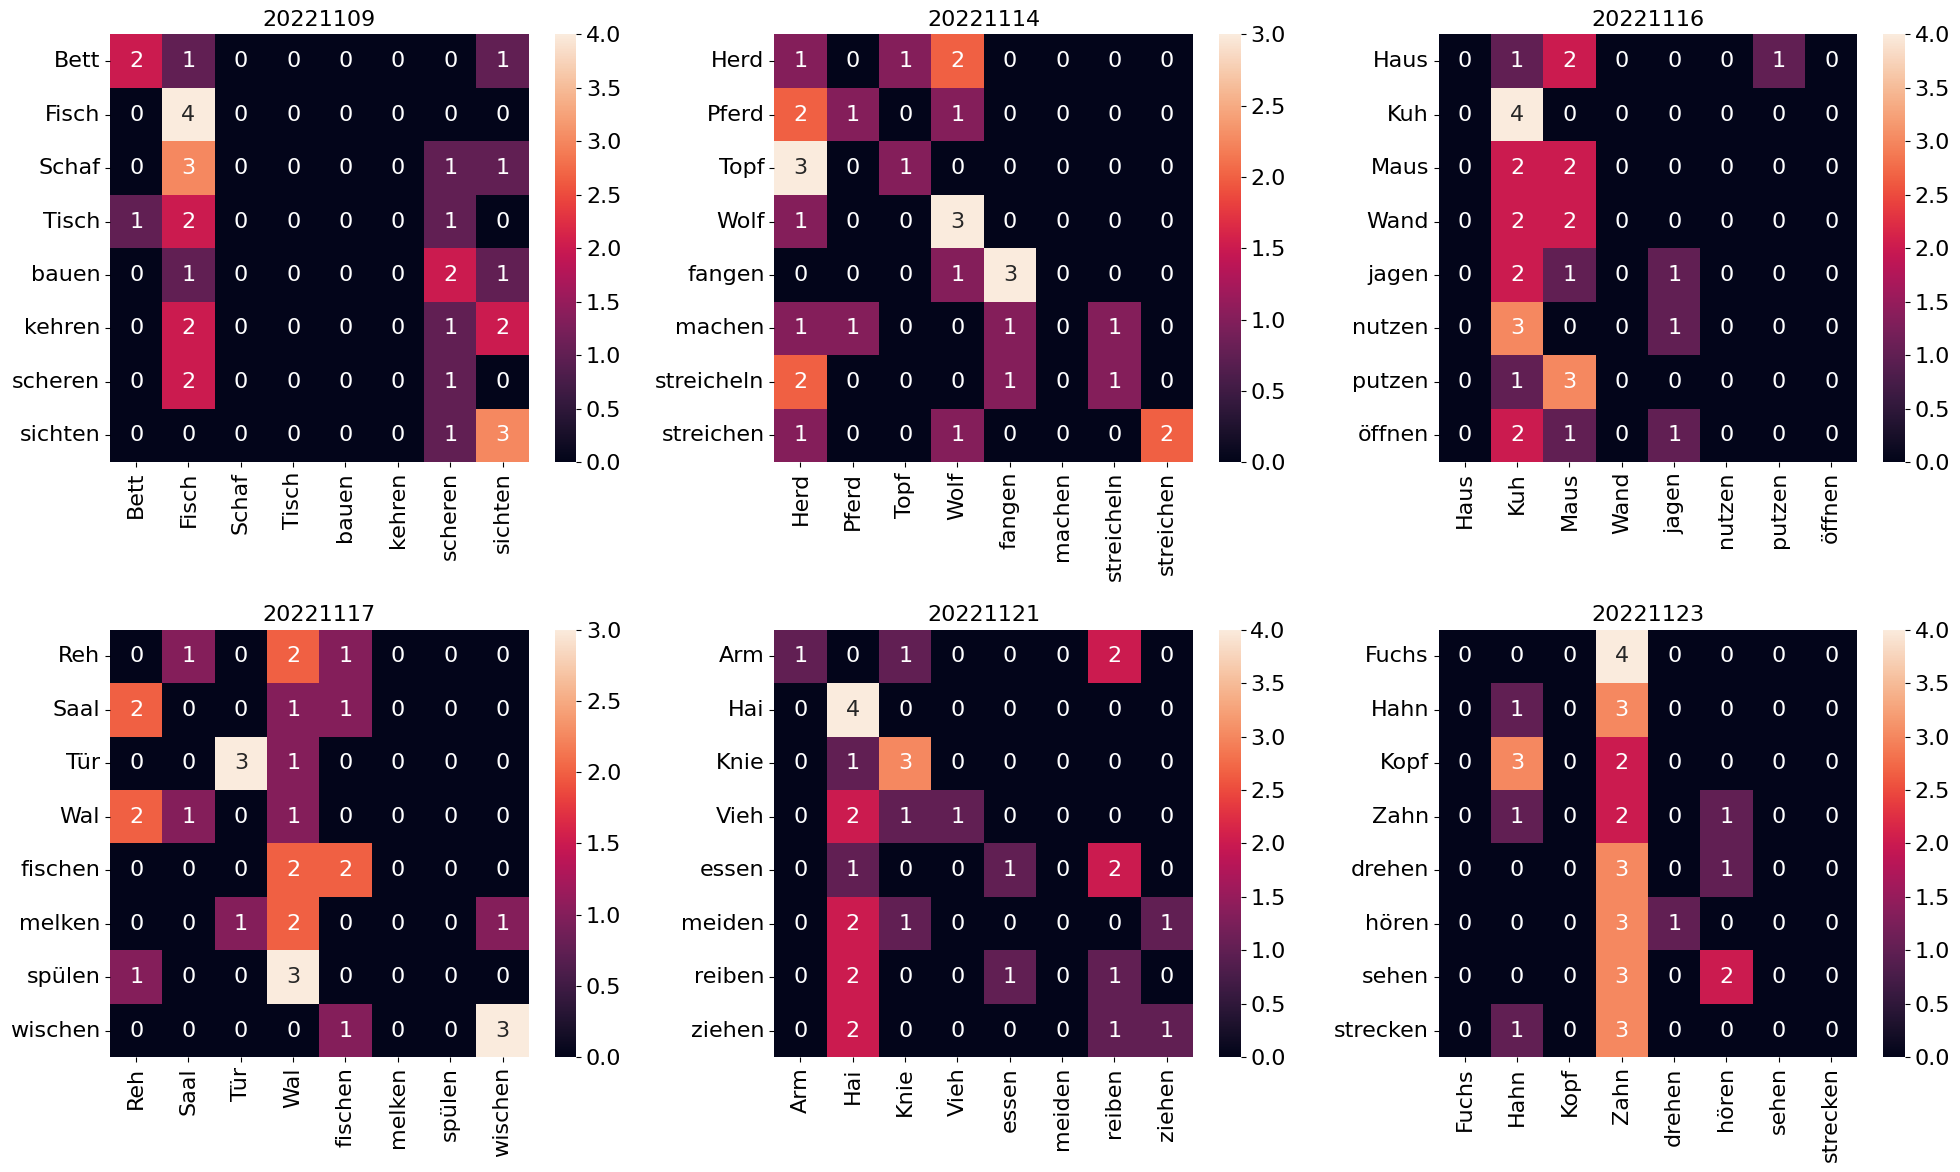

In [21]:
plot_confusion_matrix("rnn", "reg", rnn_reg_visualization_dict, label_name = "labels_words", input_type = "test")

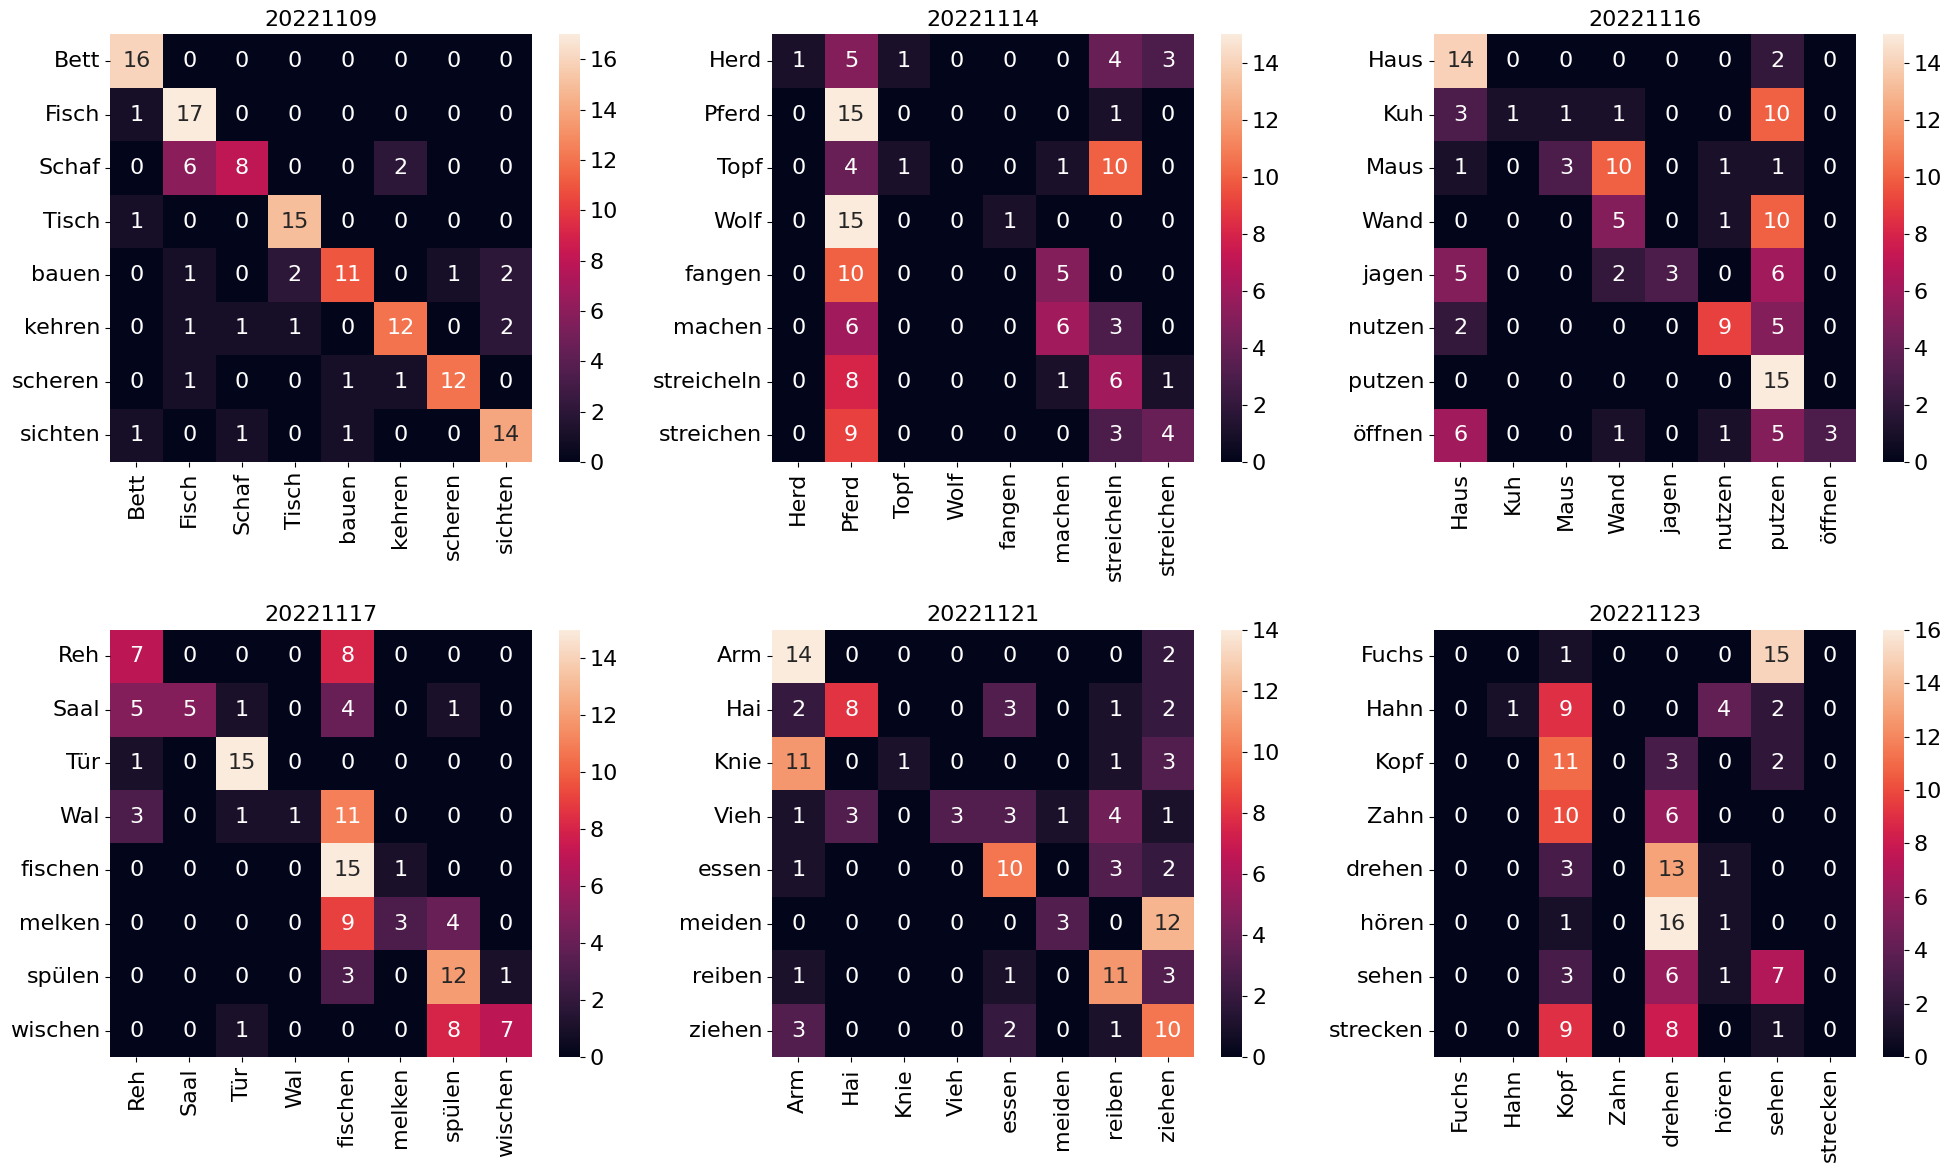

In [28]:
plot_confusion_matrix("trf", "reg", trf_reg_visualization_dict, label_name = "labels_words", input_type = "train")

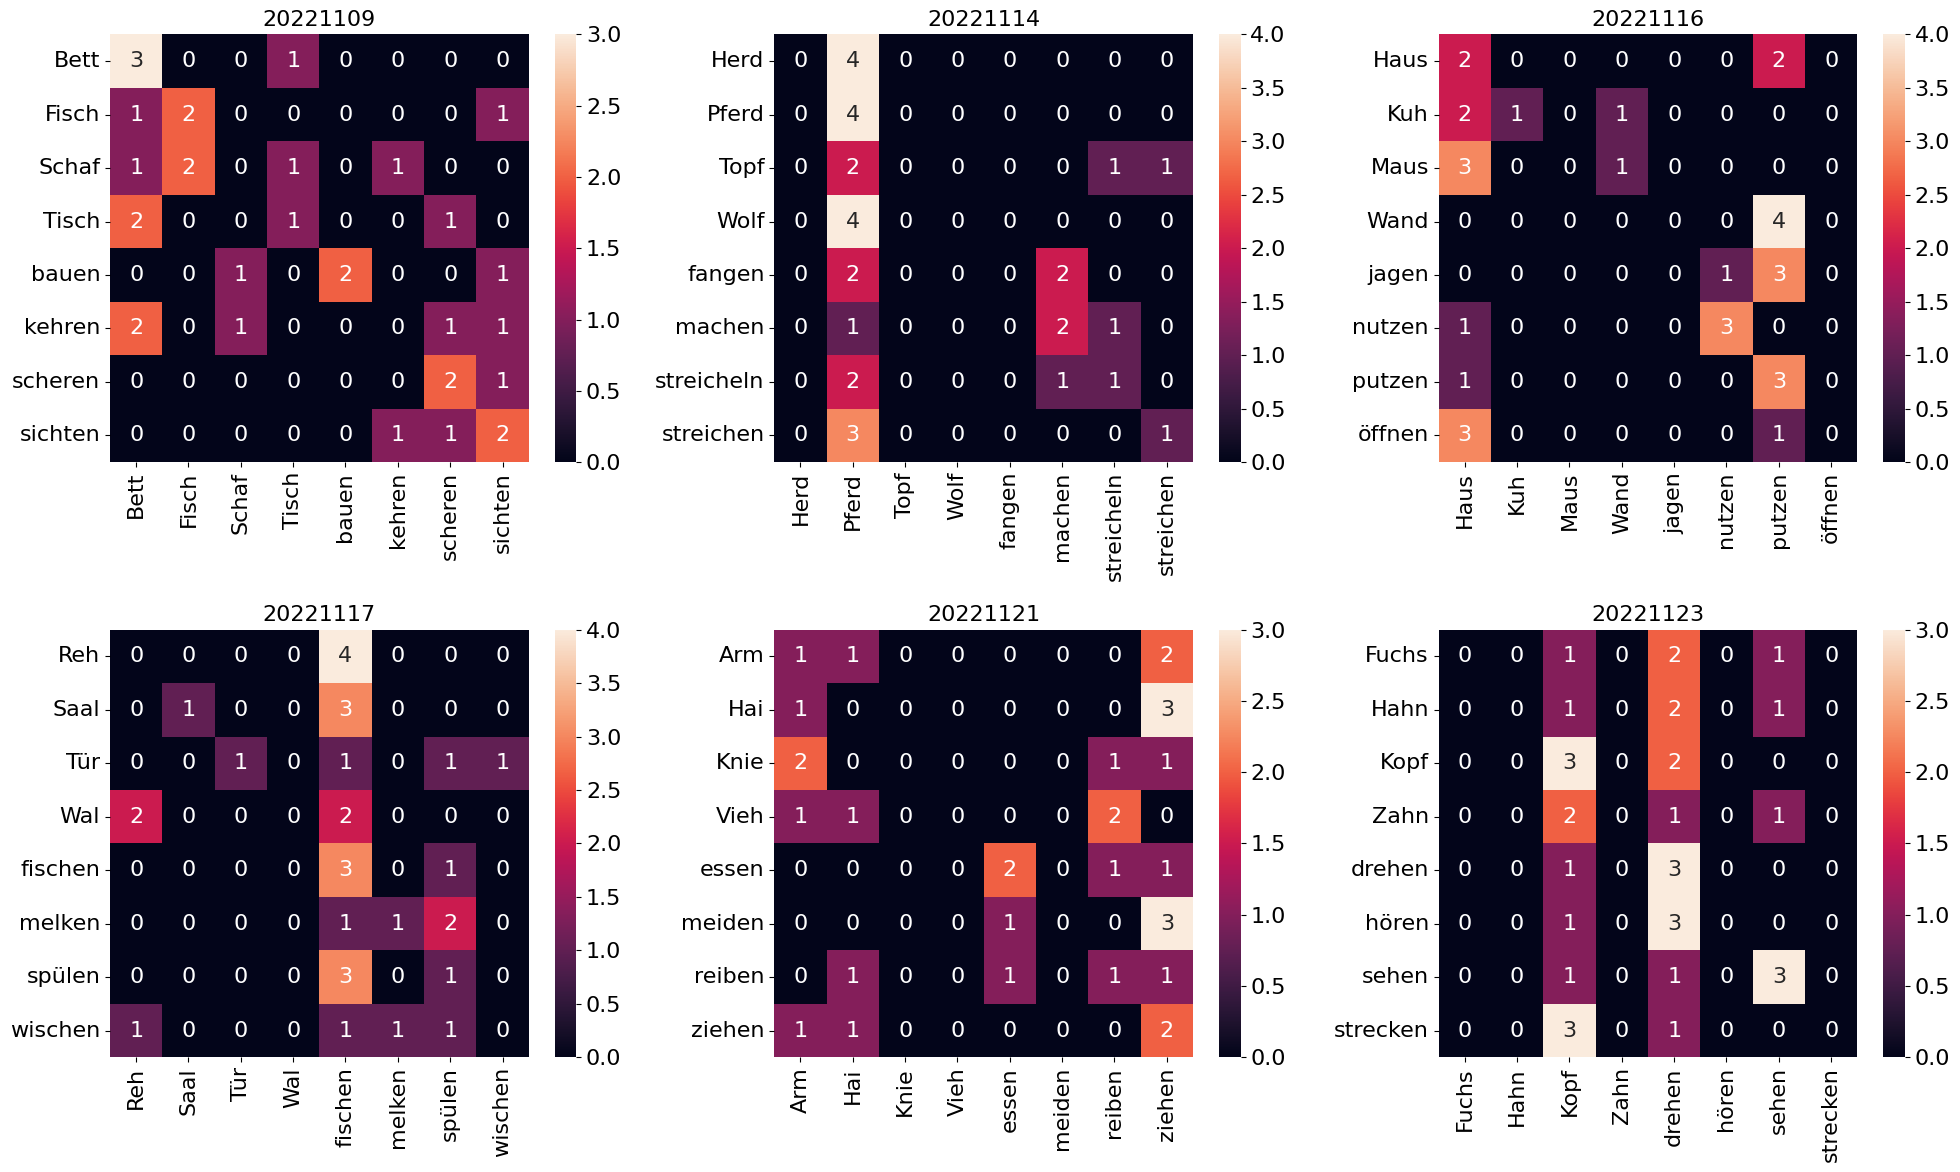

In [29]:
plot_confusion_matrix("trf", "reg", trf_reg_visualization_dict, label_name = "labels_words", input_type = "test")

### Permutation importances

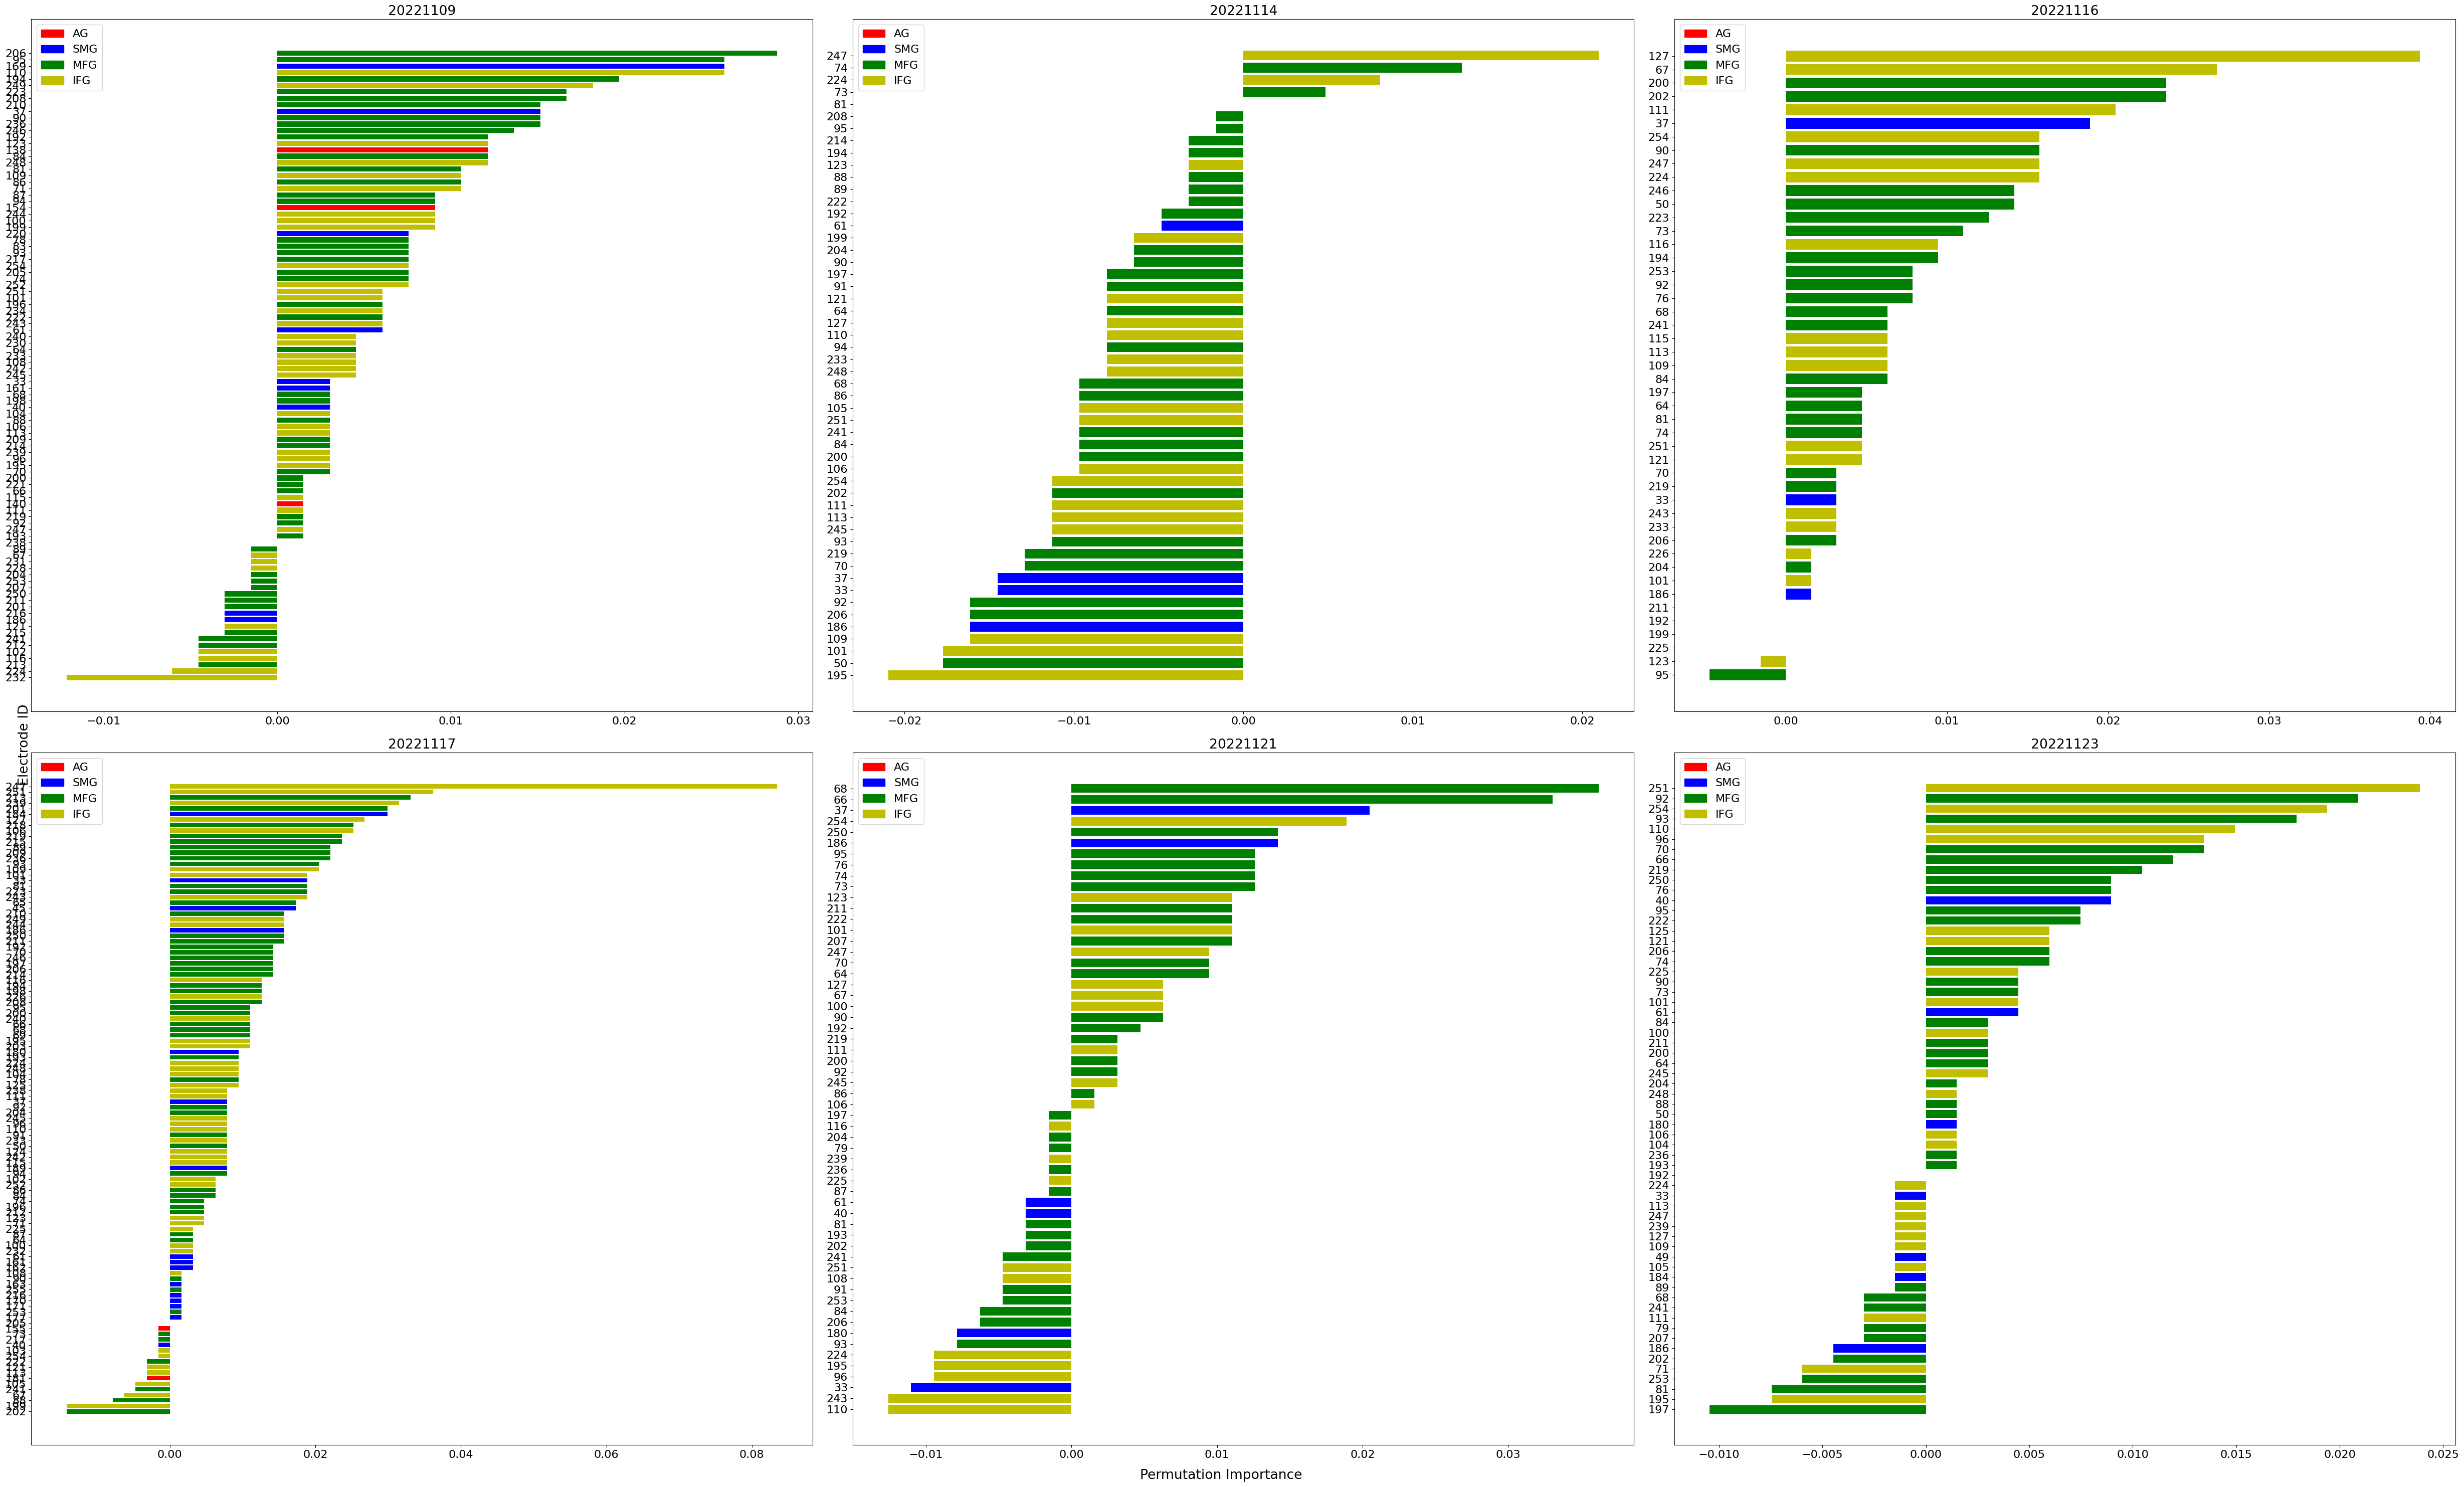

In [36]:
plot_permutation_importance("svm", "clf", svm_clf_visualization_dict, label_name = "labels_words", input_type = "train")

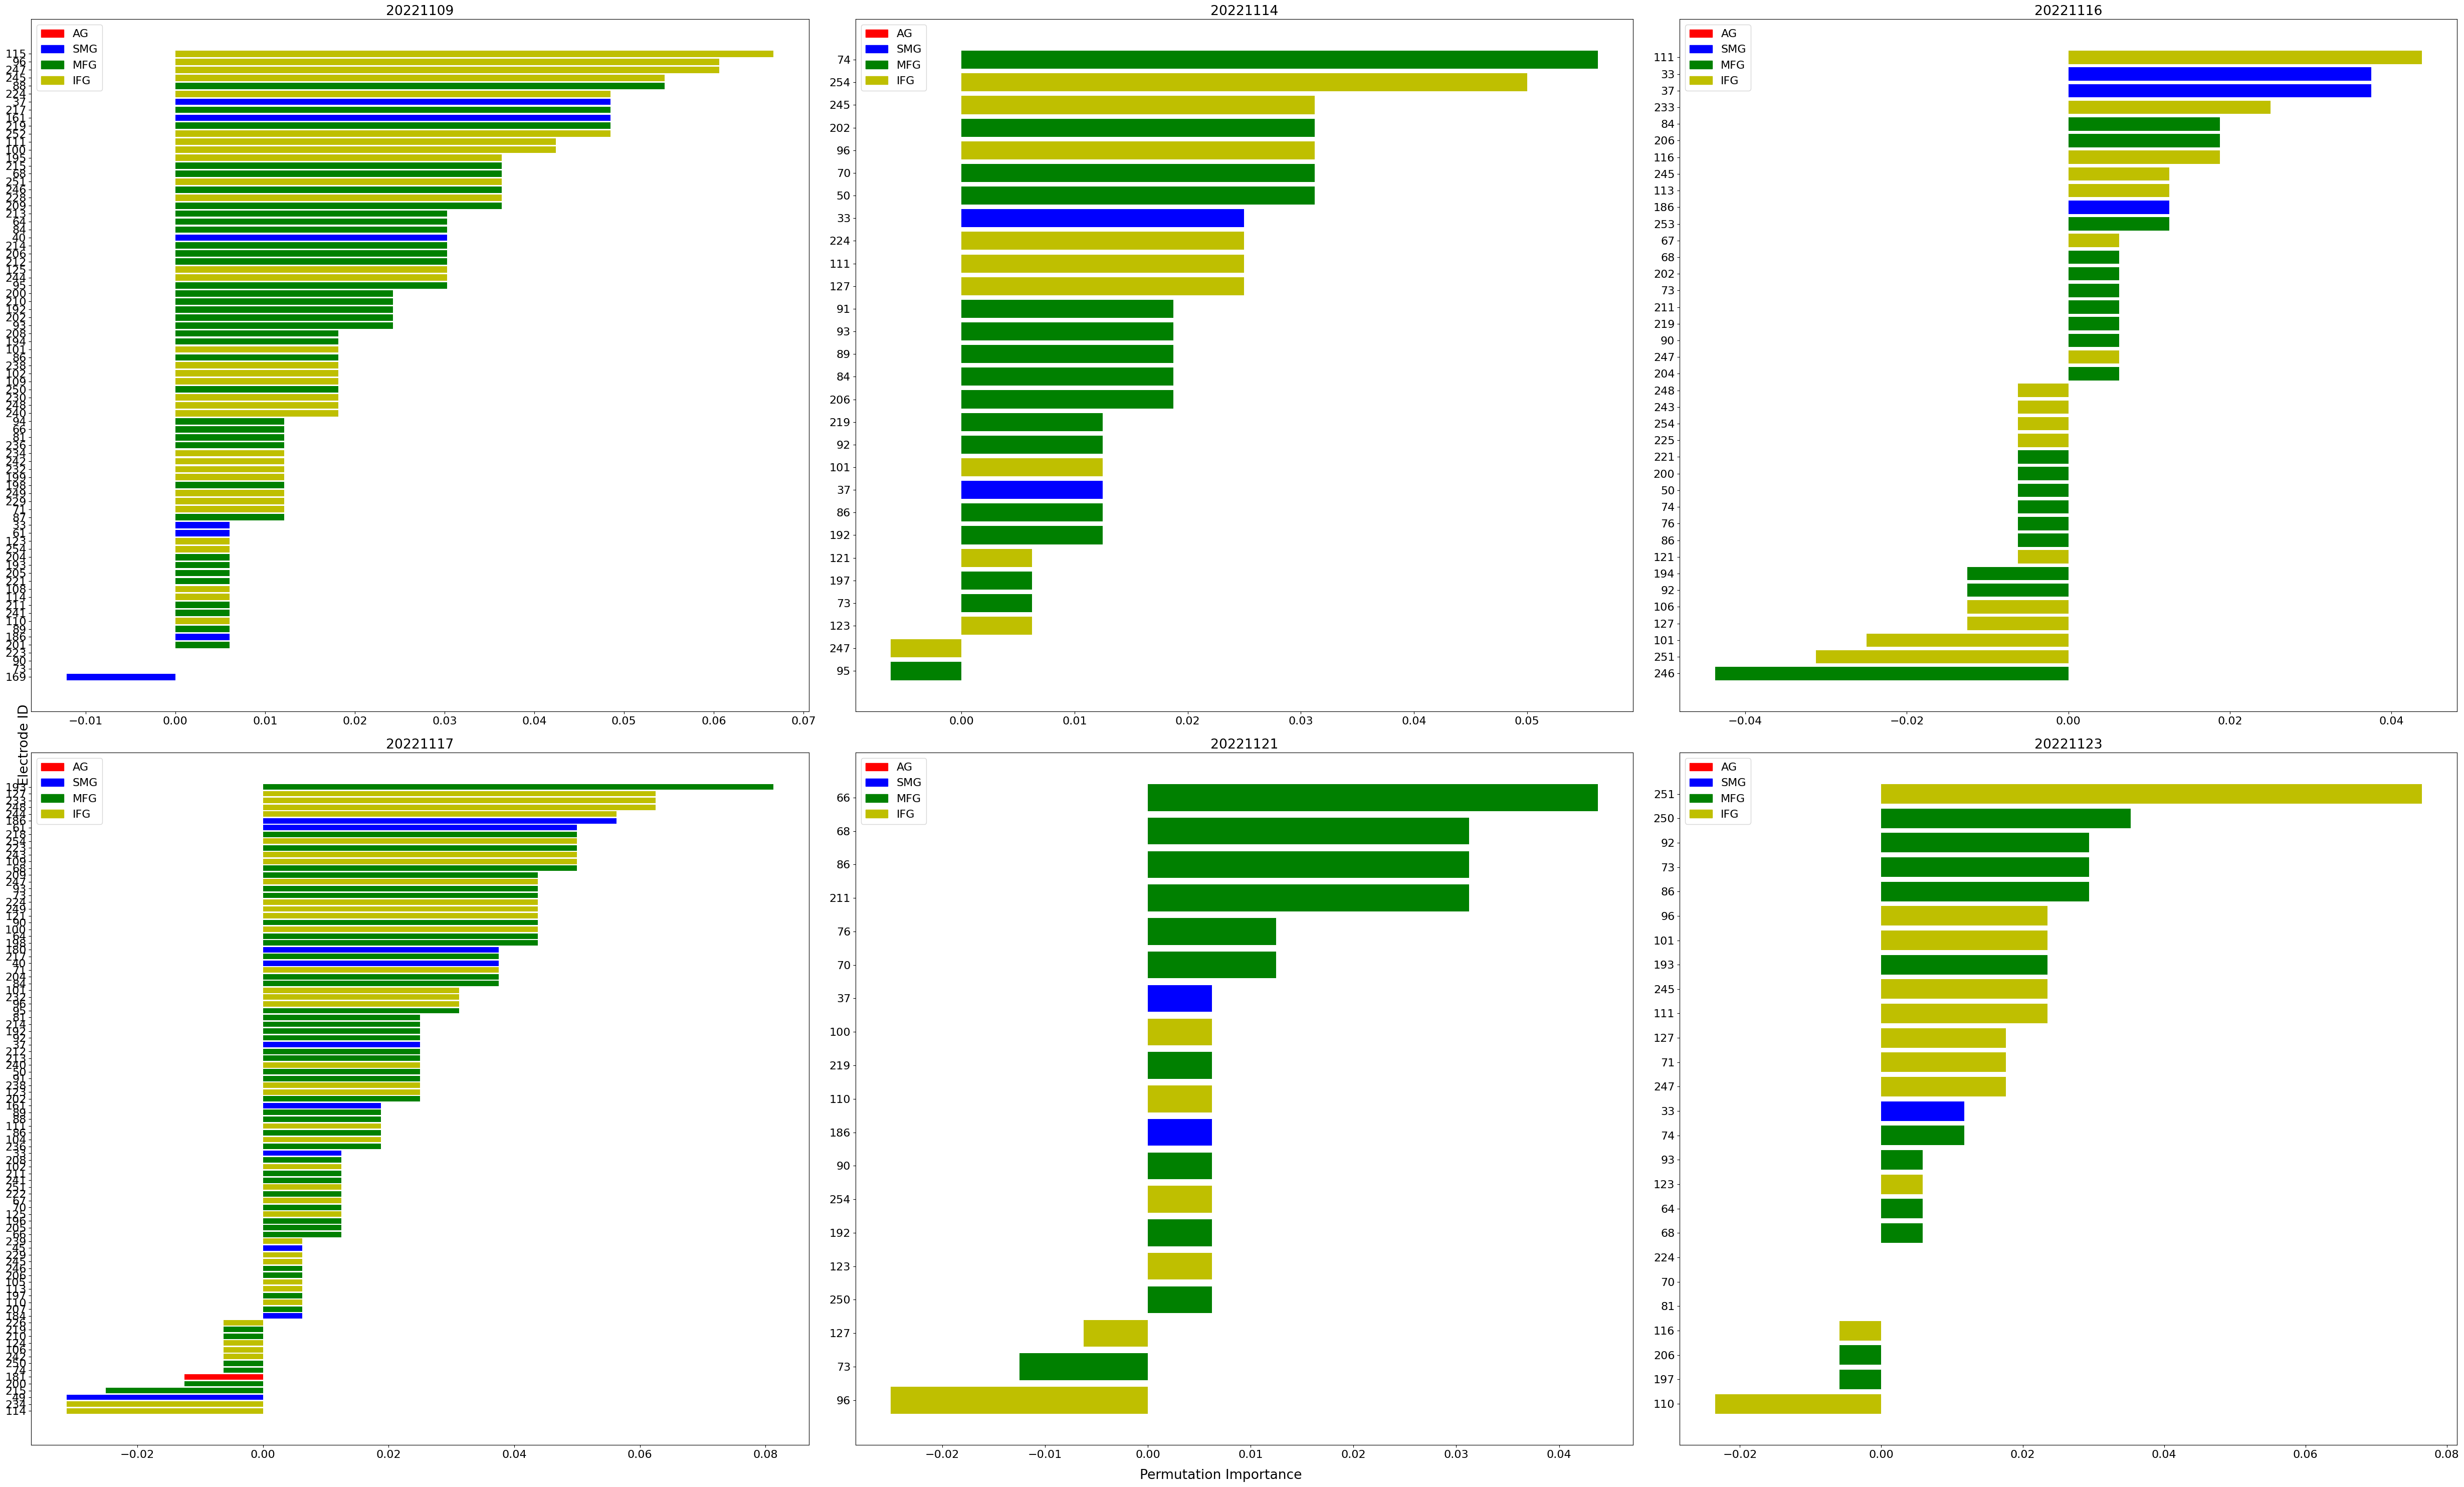

In [38]:
plot_permutation_importance("svm", "clf", svm_clf_visualization_dict, label_name = "labels_words", input_type = "test")

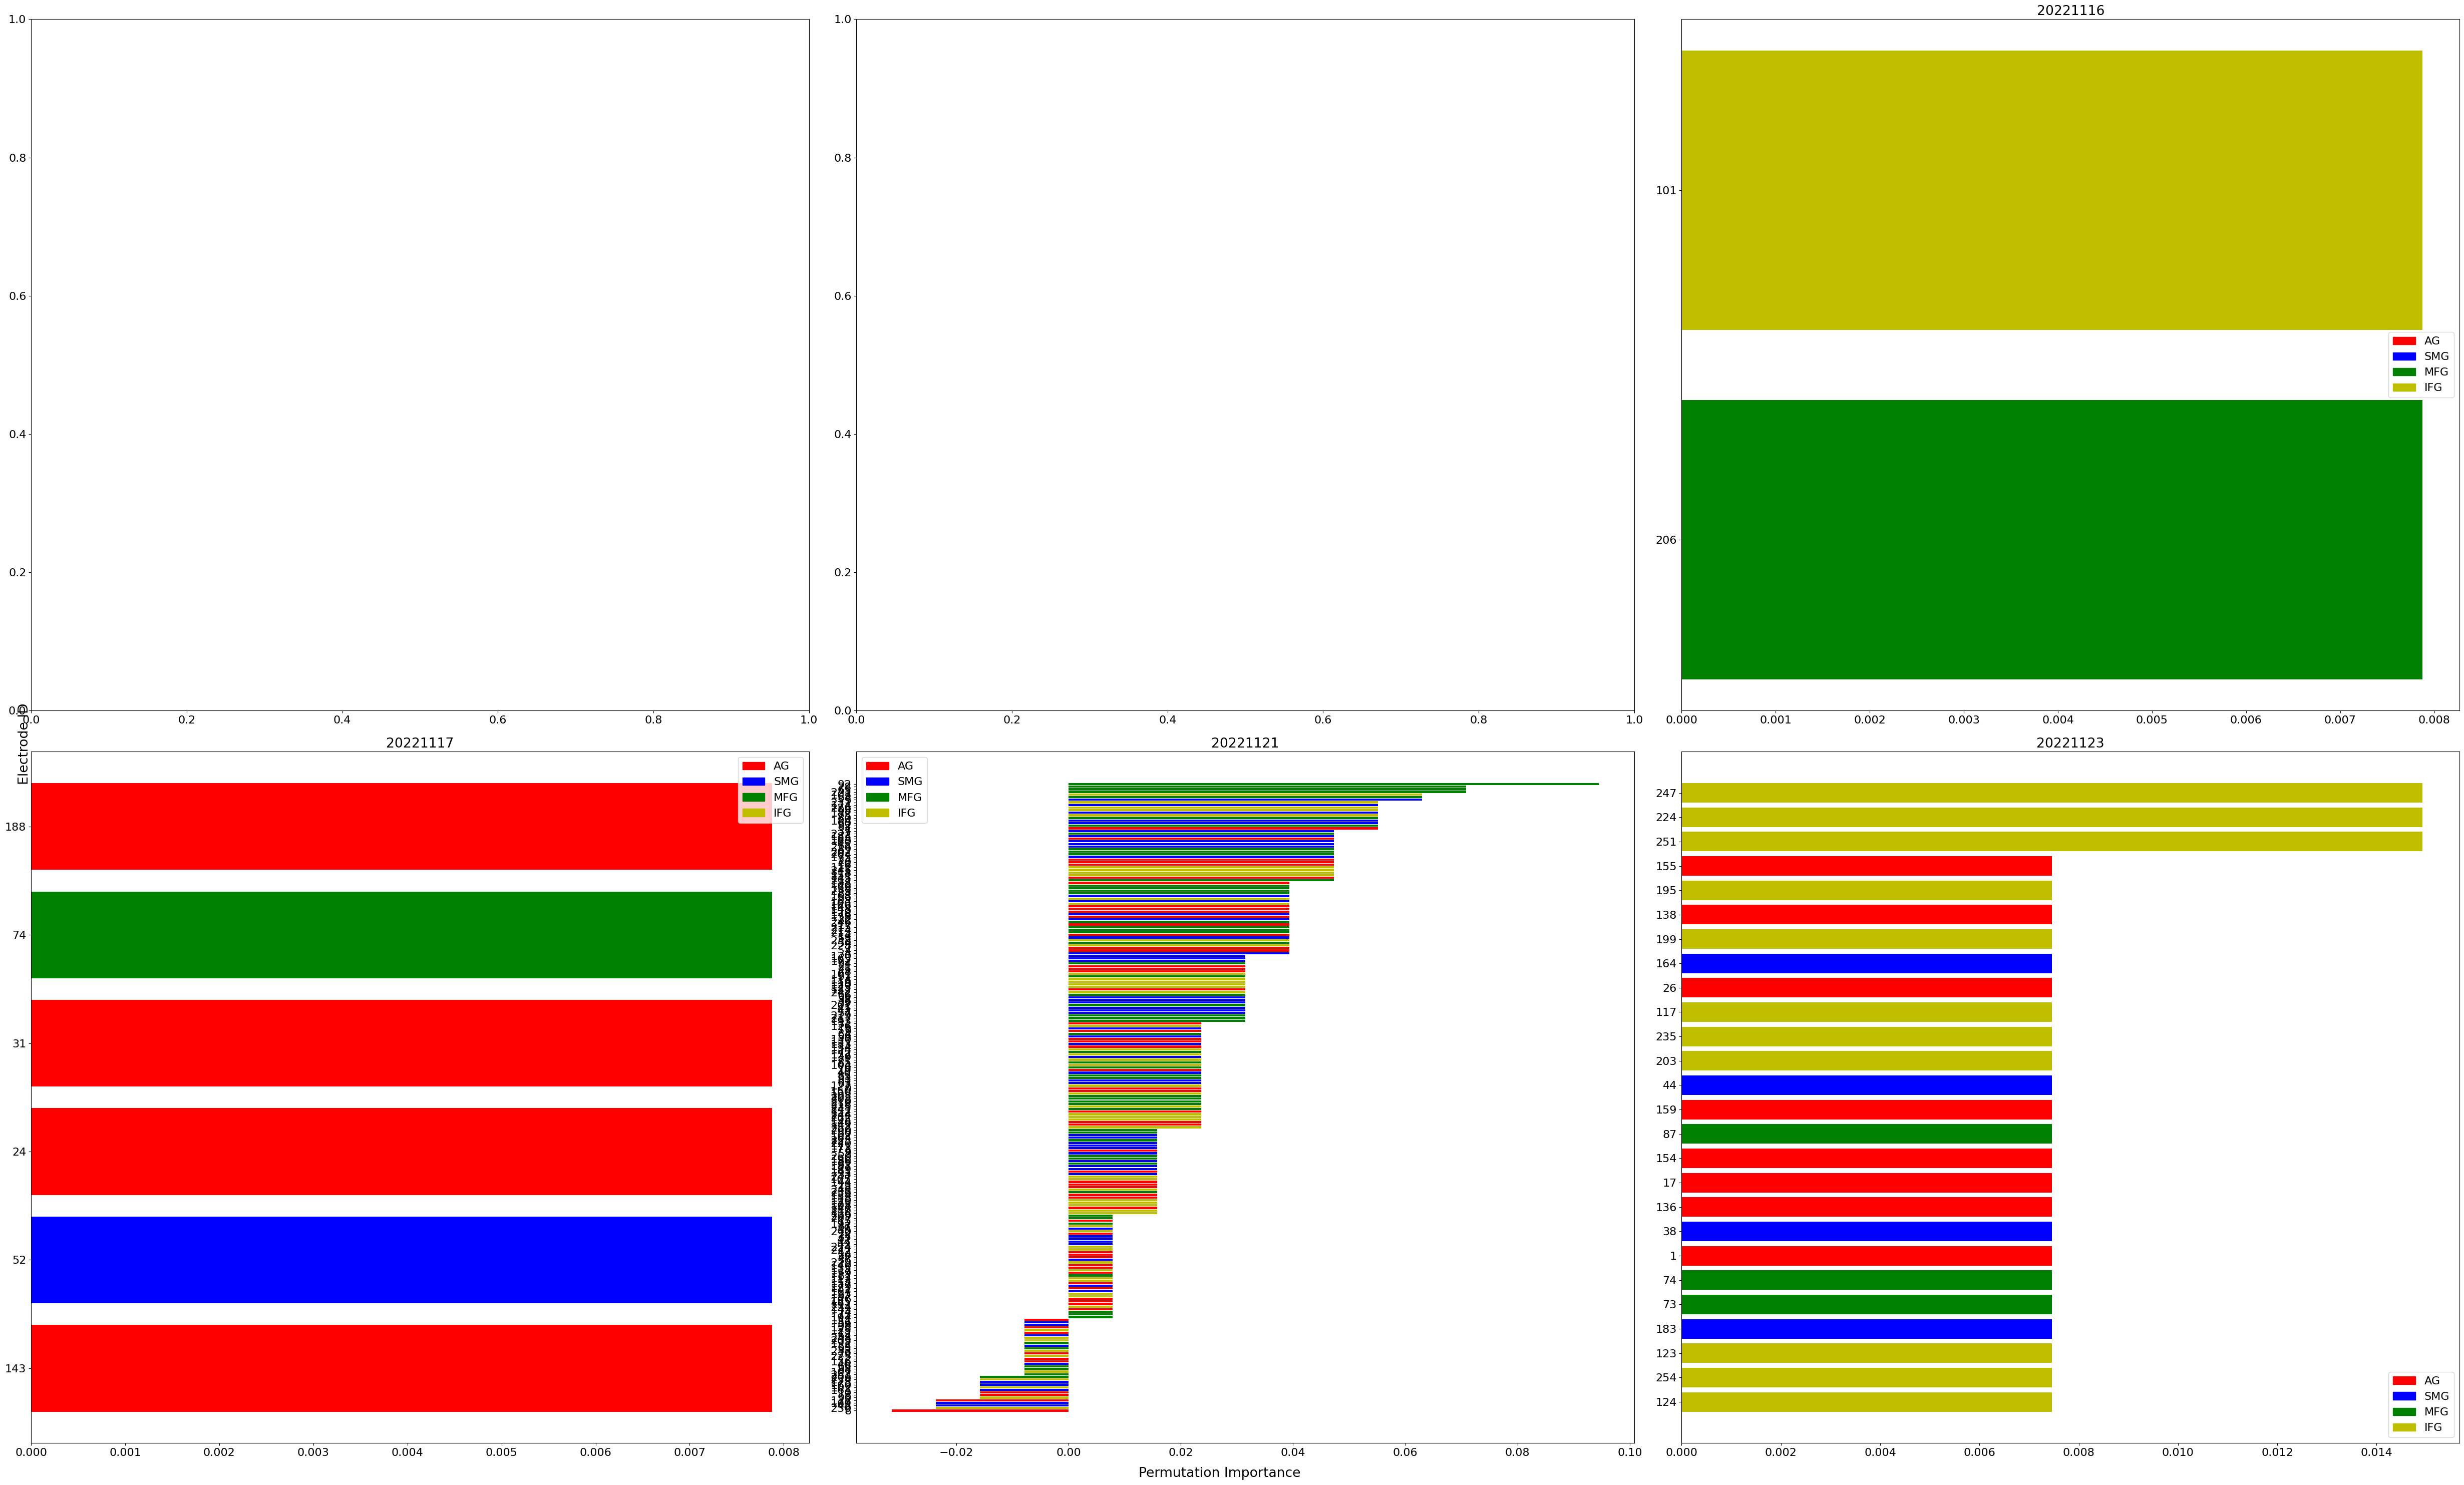

In [43]:
plot_permutation_importance("trf", "clf", trf_clf_visualization_dict, label_name = "labels_words", input_type = "train")

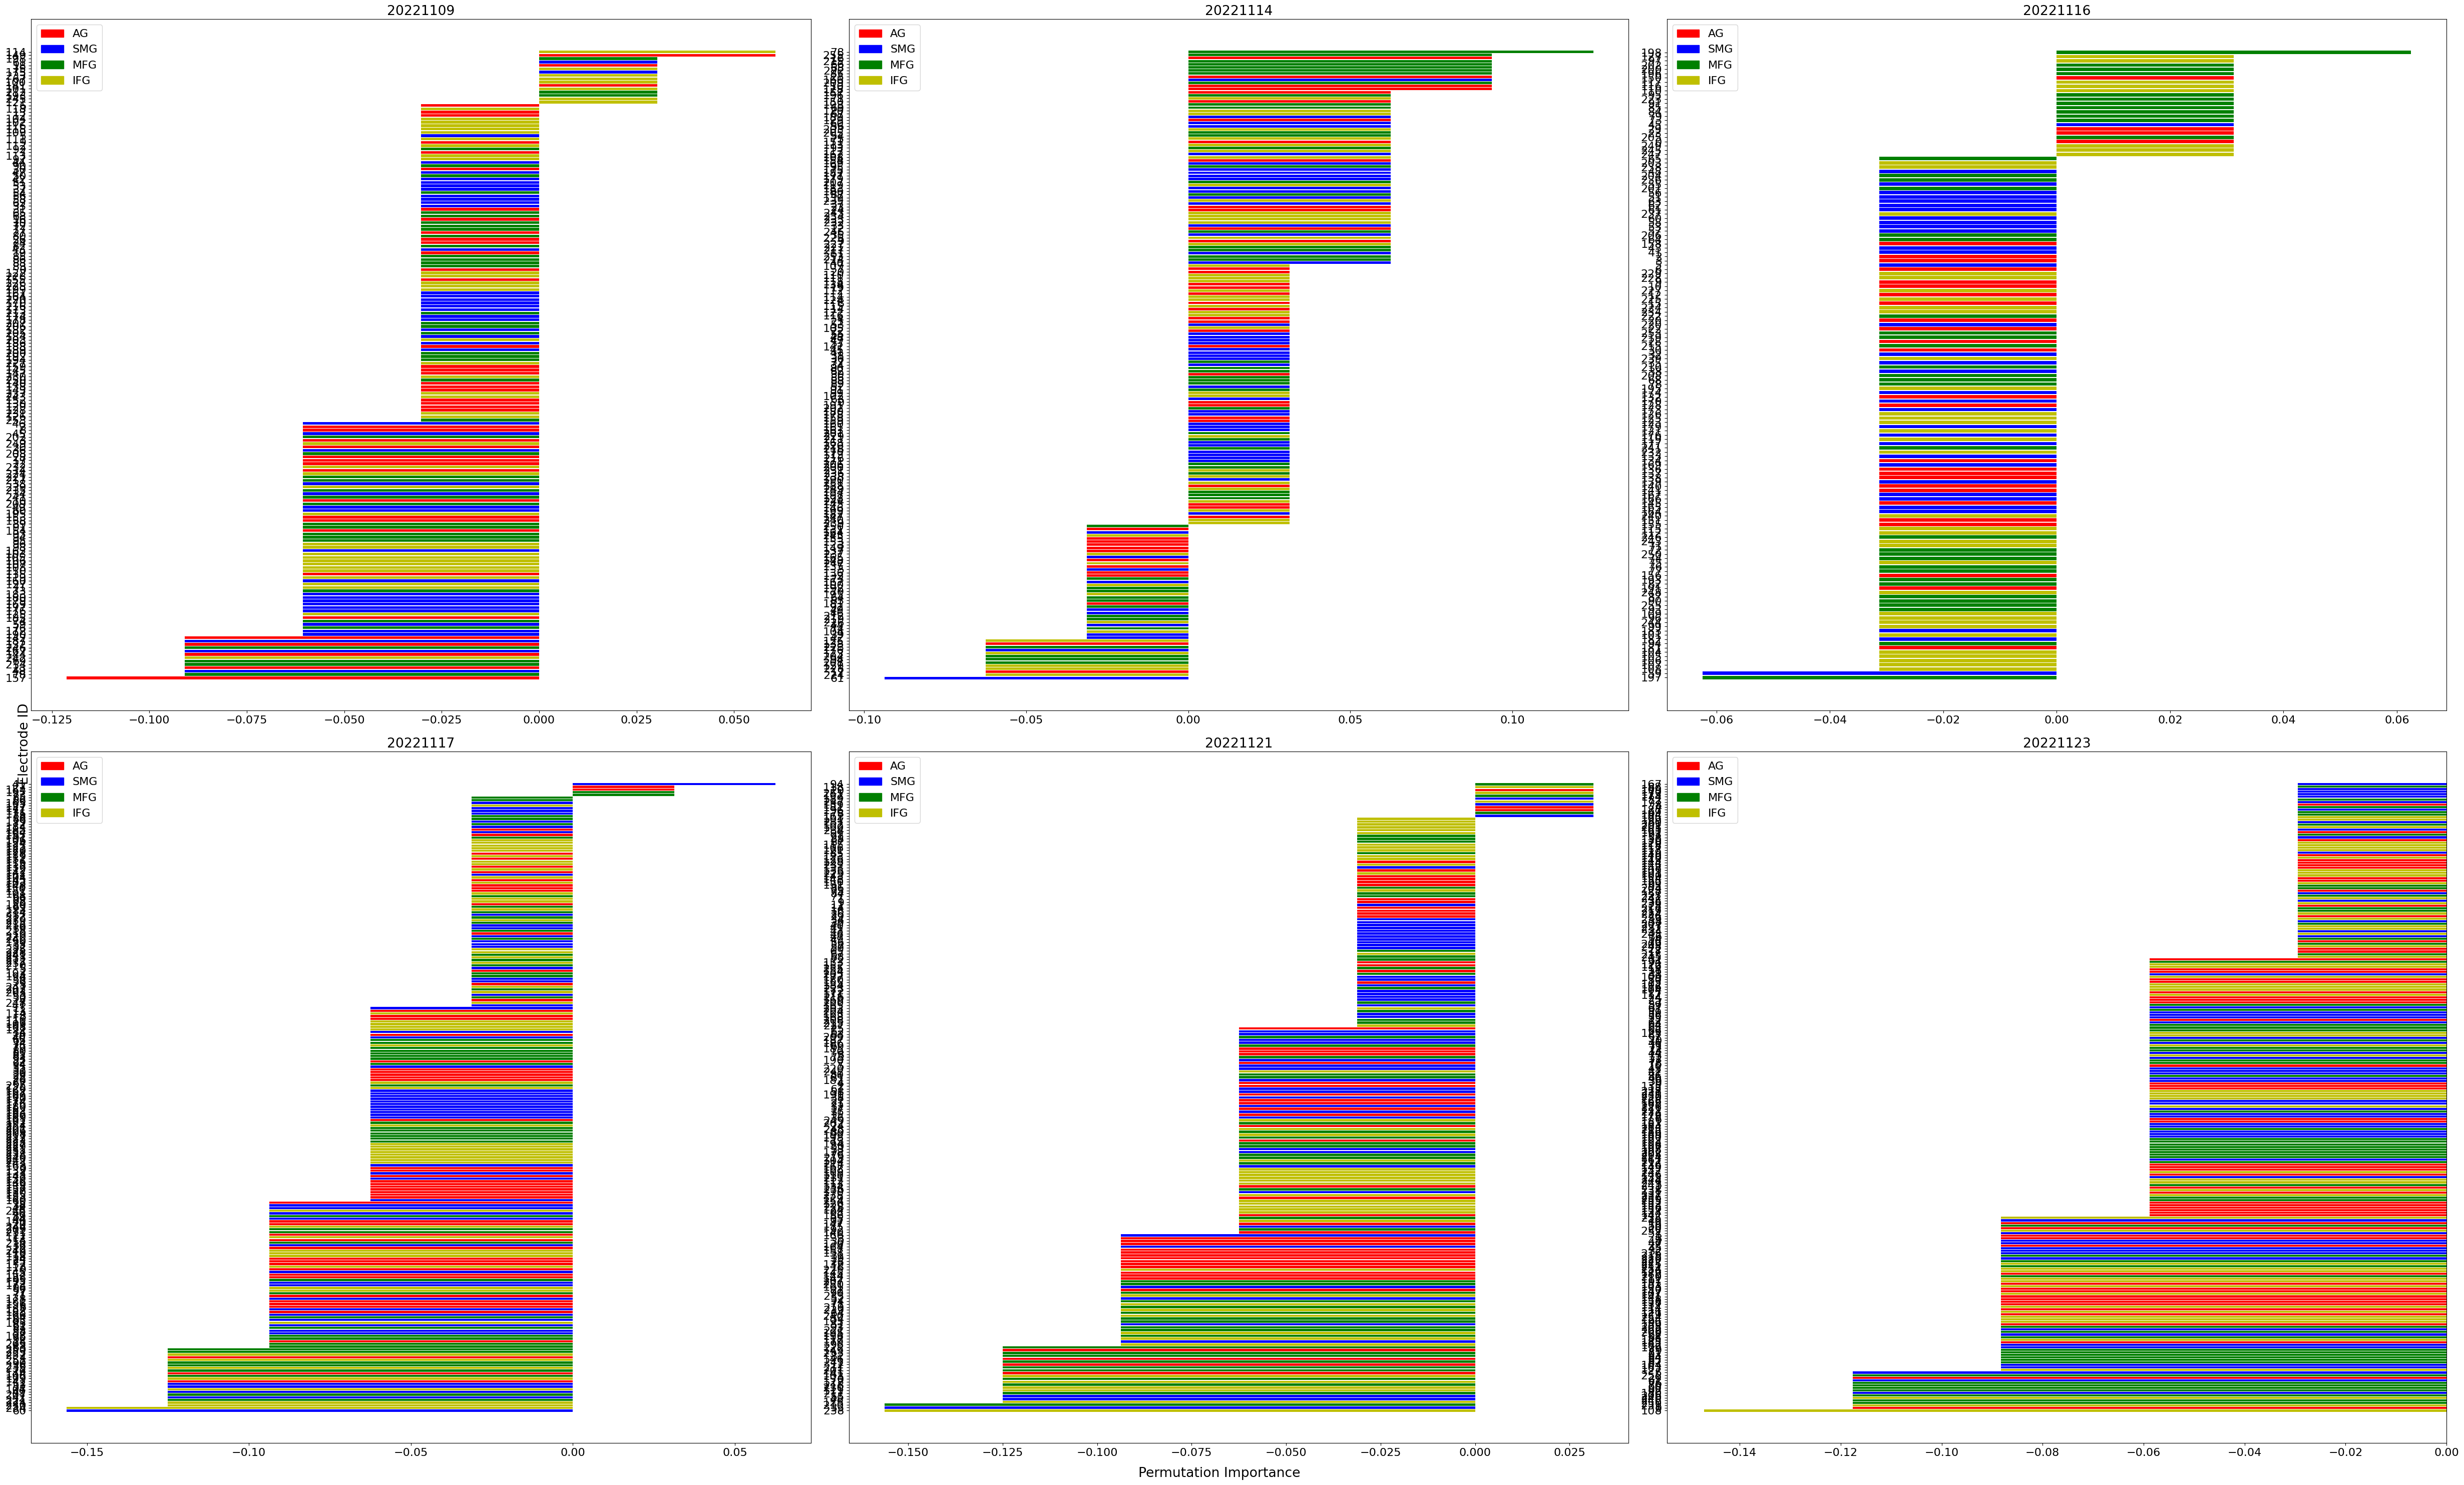

In [44]:
plot_permutation_importance("trf", "clf", trf_clf_visualization_dict, label_name = "labels_words", input_type = "test")

## Additional visualizations

### Semantic similarity comparison with confusion matrix

In [ ]:
visualization_result = calculate_visualization_data(
    "svm",
    "clf",
    label_names=["labels_words"],
    visualization_options=["confusion_matrix", "semantic_similarity"]
)

100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


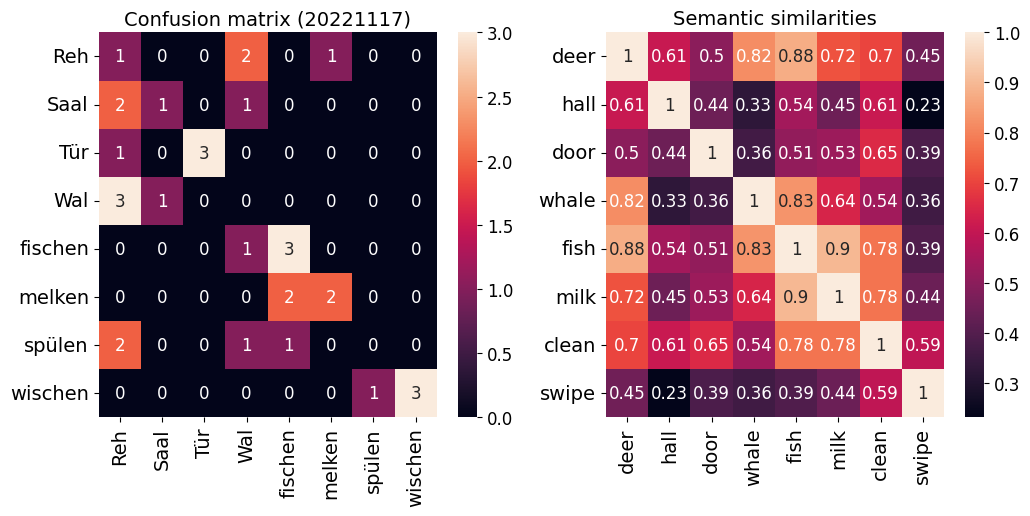

In [17]:
session_id = "20221117"
plt.rcParams.update({'font.size': 12})
cm = visualization_result.confusion_matrix["labels_words"]["test"][session_id]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs = axs.flatten()

cm_plot = sns.heatmap(cm, annot=True, ax=axs[0])
cm_plot.set_title(f"Confusion matrix ({session_id})", fontsize=14)
cm_plot.set_yticklabels(cm_plot.get_yticklabels(), rotation=0)
cm_plot.tick_params(labelsize=14)

sem_plot = sns.heatmap(visualization_result.sem_sim_dict['glove-twitter-25'][session_id], annot=True, ax=axs[1])
sem_plot.set_title("Semantic similarities", fontsize=14)
sem_plot.set_yticklabels(sem_plot.get_yticklabels(), rotation=0)

sem_plot.tick_params(labelsize=14)

#fig.savefig(f"{FIGURE_DIR}/cm_semsim_{session_id}.svg")
plt.show()

### Semantic similarity between different embeddings

In [6]:
model_type = "svm"
task_type = "clf"
visualization_options = ["semantic_similarity"]
visualization_dict = calculate_visualization_data(
    model_type,
    task_type,
    label_names=["label_names"],
    visualization_options=visualization_options,
)

100%|██████████| 6/6 [00:14<00:00,  2.42s/it]


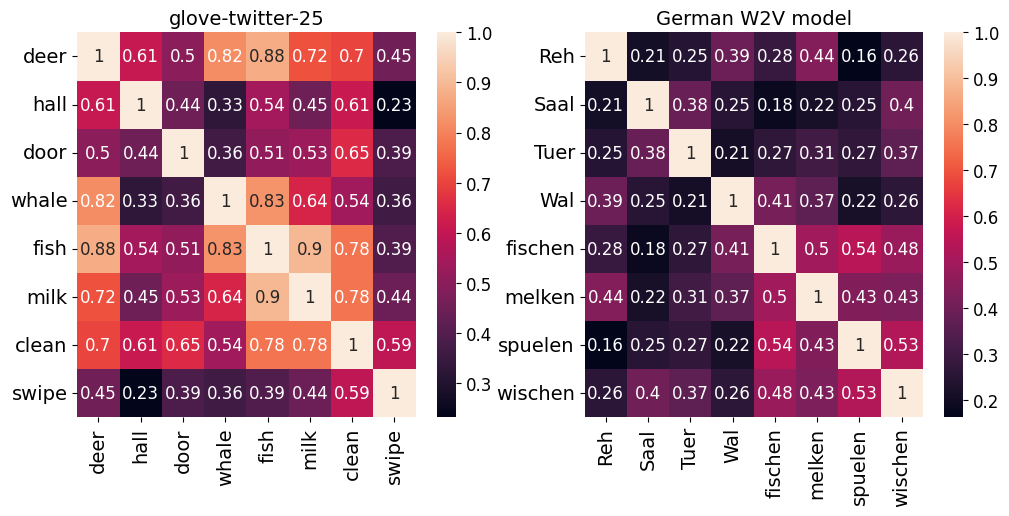

In [12]:
session_id = "20221117"
plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs = axs.flatten()

cm_plot = sns.heatmap(visualization_dict.sem_sim_dict["glove-twitter-25"][session_id], annot=True, ax=axs[0])
cm_plot.set_title("glove-twitter-25", fontsize=14)
cm_plot.tick_params(labelsize=14)
cm_plot.set_yticklabels(cm_plot.get_yticklabels(), rotation=0)

sem_plot = sns.heatmap(visualization_dict.sem_sim_dict["german.model"][session_id], annot=True, ax=axs[1])
sem_plot.set_title("German W2V model", fontsize=14)
sem_plot.tick_params(labelsize=14)
sem_plot.set_yticklabels(sem_plot.get_yticklabels(), rotation=0)

# fig.savefig(f"{FIGURE_DIR}/semsim_comparison_{session_id}.svg")
plt.show()

### Permutation importance comparison

In [65]:
task_type = "clf"
model_types = ["svm", "rnn", "trf"]
result_dict = {}

for model_type in model_types:
    output_path = f"{RESULT_DIR}/final_results/retrained_models/{model_type}_{task_type}/{model_type}_{task_type}_visualization_dict.pkl"
    result_dict[model_type] = unpickle_object(output_path)["permutation_importance"]

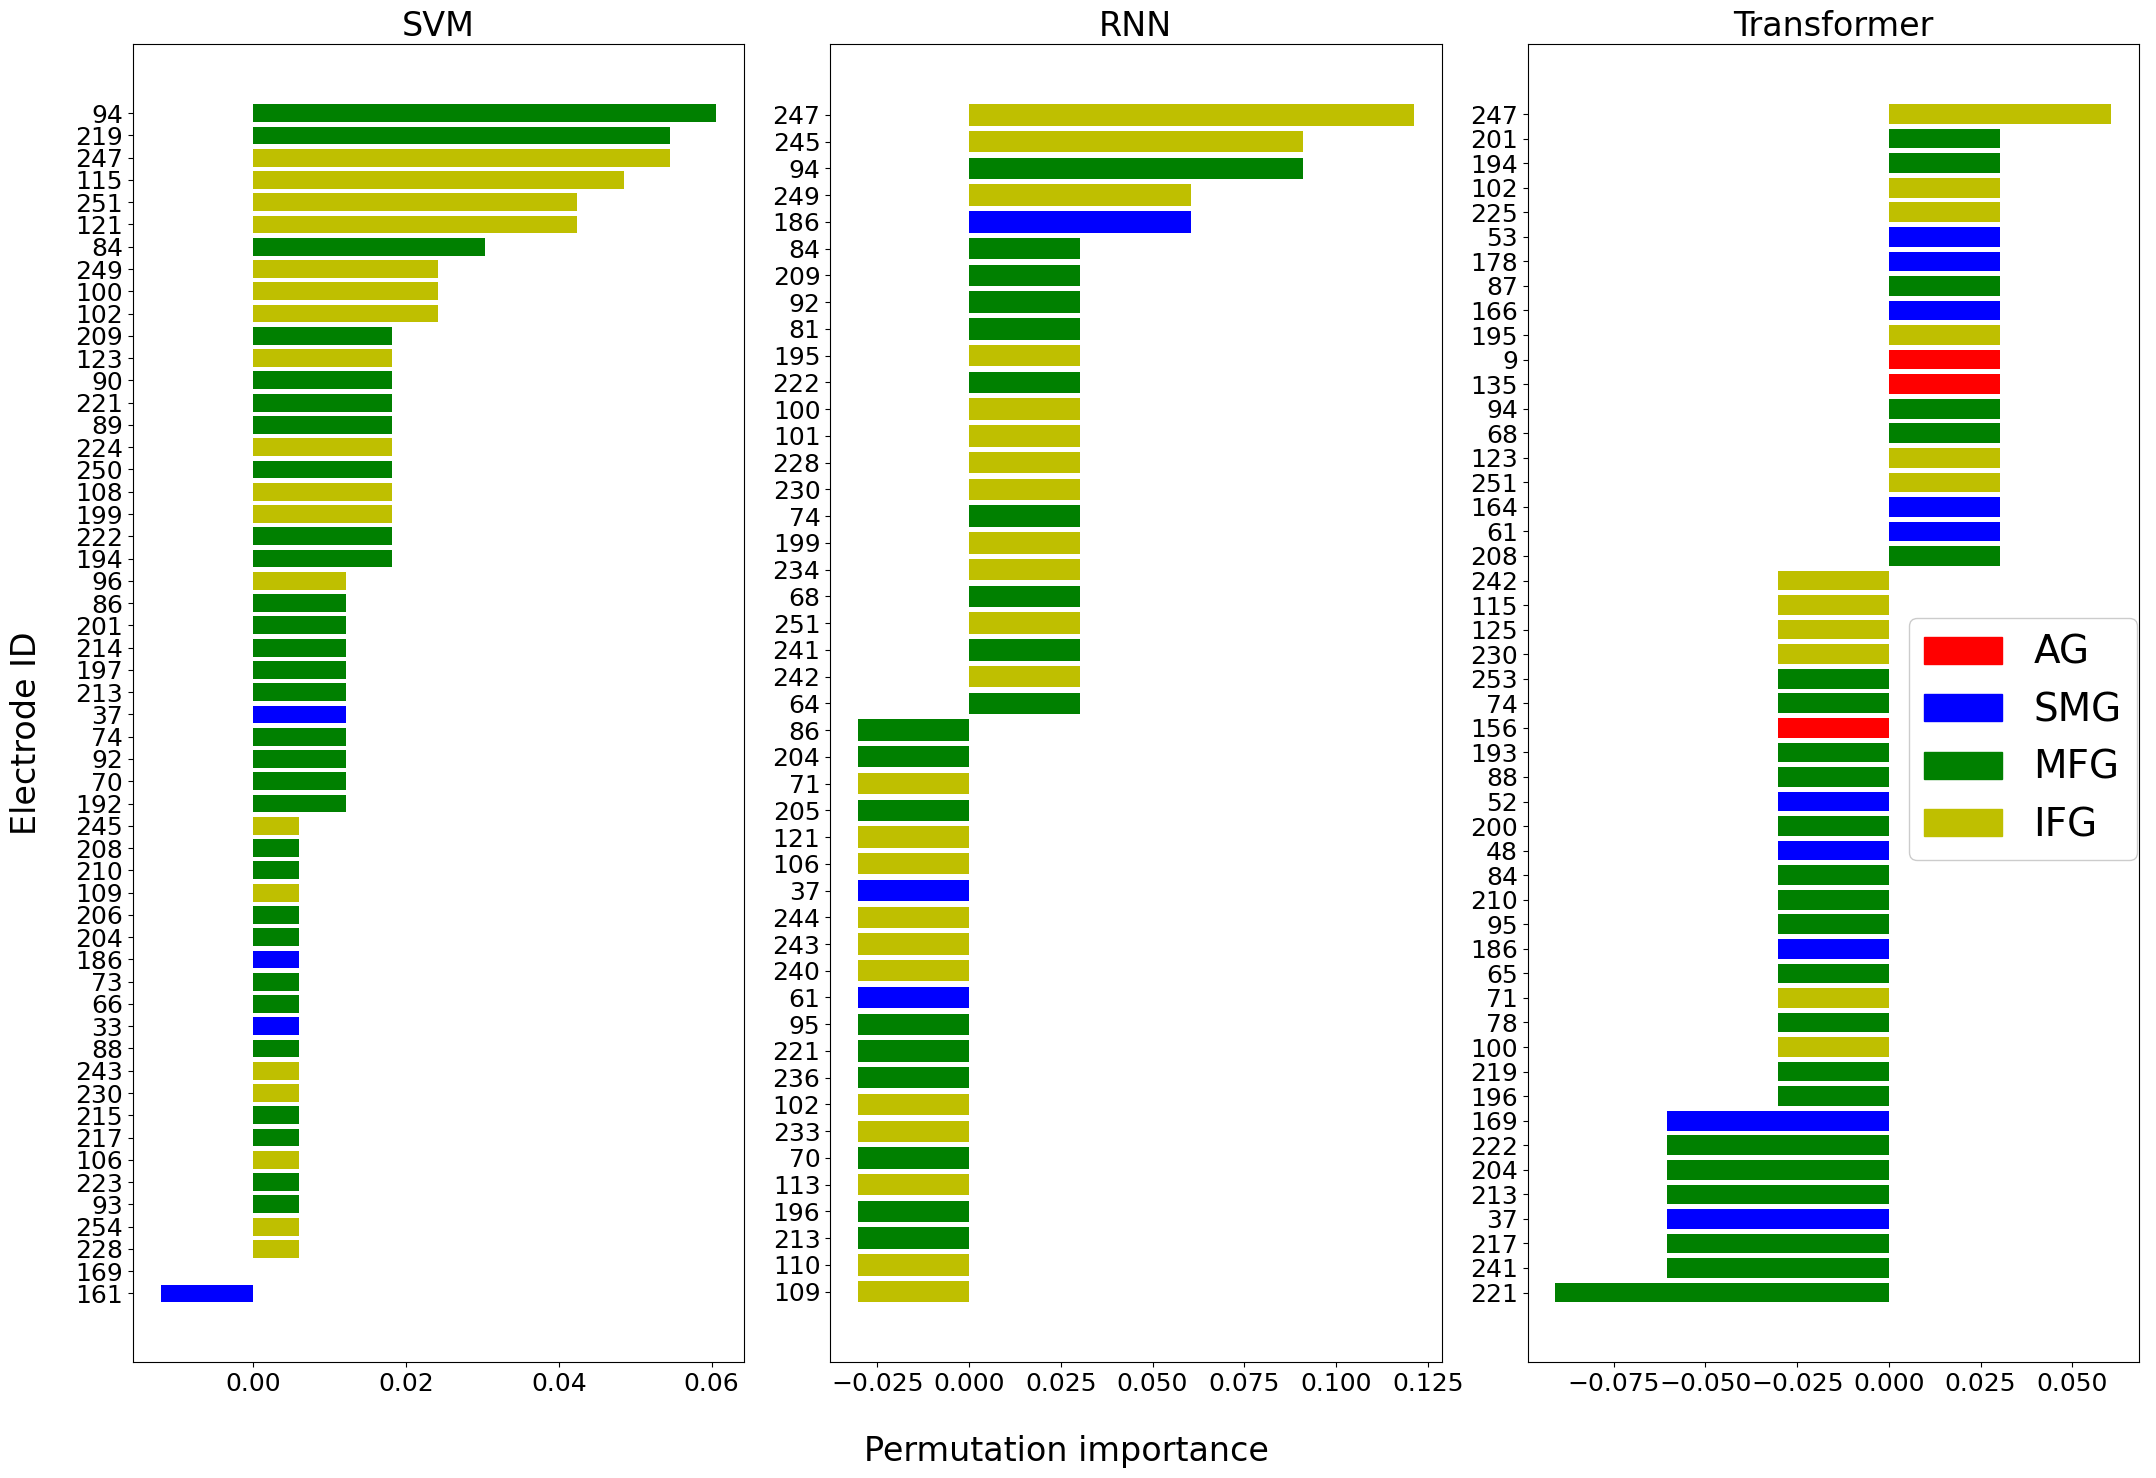

In [71]:
label_name = "syncat_labels"
output_type = "test"
session_id = "20221109"
plt.rcParams.update({'font.size': 18})

features, idx_color_list = get_permutation_importance_metadata()

fig, axs = plt.subplots(1, 3, figsize=(22, 15))

for model_type, ax in zip(model_types, axs.flatten()):
    importances = result_dict[model_type][label_name][output_type][session_id]
    if model_type == "svm":
        importances = importances["importances_mean"]
    sorted_idx = importances.argsort()
    non_null_idx = np.asarray([i for i, imp in enumerate(importances[sorted_idx]) if imp])

    ax.barh(features[sorted_idx][non_null_idx],
            importances[sorted_idx][non_null_idx],
            color=np.asarray(idx_color_list)[sorted_idx][non_null_idx])
    ax.set_title(MODEL_PREFIX_TO_NAME_DICT[model_type], fontsize=24)
        #flattened_axs[i].set_xlabel("")
        #flattened_axs[i].set_ylabel("")
    handles = [Patch(color=color, label=label) for label, color in BRAIN_COLOR_DICT.items()]
fig.legend(handles=handles, loc="right", fontsize=28, framealpha=1)
fig.supxlabel("Permutation importance", fontsize=24)
fig.supylabel("Electrode ID", fontsize=24)

plt.tight_layout(rect=[0.01, 0, 1, 1])

# fig.savefig(f"{FIGURE_DIR}/cross_model_perm_{session_id}.svg")

### Check number of trials and labels

In [43]:
data_split = load_train_test_ids("experiment1")

for session_id, split in data_split.items():

    result_entry = {"session_id": session_id}
    label_dict = get_label_dict(session_id, "experiment1", "clf")
    
    train_idx, test_idx = split["train_ids"], split["test_ids"]

    print(f"Trials in session {session_id}: {len(train_idx) + len(test_idx)}")

Trials in session 20221117: 159
Trials in session 20221121: 159
Trials in session 20221114: 156
Trials in session 20221109: 165
Trials in session 20221123: 168
Trials in session 20221116: 159


In [47]:
data_split = load_train_test_ids("experiment2")

for session_id, split in data_split.items():

    result_entry = {"session_id": session_id}    
    train_idx, test_idx = split["train_ids"], split["test_ids"]

    print(f"Trials in session {session_id}: {len(train_idx) + len(test_idx)}")

Trials in session 20240708: 650


In [ ]:
for target_word, sem_cat, syn_cat in zip(TARGET_WORDS, SEMANTIC_CAT, SYNTACTIC_CAT):
    print(target_word, sem_cat, syn_cat)

Tisch_1 house noun
Herd_1 house noun
Haus_1 house noun
Saal_1 house noun
Bett_1 house noun
Wand_1 house noun
Tür_1 house noun
Topf_1 house noun
Fisch_1 animal noun
Pferd_1 animal noun
Maus_1 animal noun
Wal_1 animal noun
Schaf_1 animal noun
Kuh_1 animal noun
Reh_1 animal noun
Wolf_1 animal noun
kehren_1 house verb
streichen_1 house verb
putzen_1 house verb
wischen_1 house verb
bauen_1 house verb
machen_1 house verb
öffnen_1 house verb
spülen_1 house verb
scheren_1 animal verb
streicheln_1 animal verb
nutzen_1 animal verb
fischen_1 animal verb
sichten_1 animal verb
melken_1 animal verb
jagen_1 animal verb
fangen_1 animal verb
Fliese_1 house noun
Liege_1 house noun
Schale_1 house noun
Stufe_1 house noun
Teppich_1 house noun
Sofa_1 house noun
Dose_1 house noun
Blume_1 house noun
Fliege_1 animal noun
Ziege_1 animal noun
Schabe_1 animal noun
Stute_1 animal noun
Biene_1 animal noun
Lama_1 animal noun
Zecke_1 animal noun
Zebra_1 animal noun
weglegen_1 house verb
anpassen_1 house verb
einräume

In [53]:
with open(f"{DATA_DIR}/brown_50_frequent_words.list") as f:
    brown_50_words = json.loads(f.read().replace("'", '"'))#[:50]

target_words = list(set(GERMAN_TO_ENGLISH_DICT[t[:-2]] for t in TARGET_WORDS))
print("Number of target words", len(set(target_words)))
print("Number of Brown words", len(brown_50_words))
brown_50_words.extend(target_words)
print("Number of Brown words after extension", len(brown_50_words))

Number of target words 121
Number of Brown words 50
Number of Brown words after extension 171


## Durations

In [ ]:
dir = f"{RESULT_DIR}/final_results/selected_results"
folders = os.listdir(dir)

total_times = {}

for model_type in ["svm", "rnn", "trf"]:
    for task_type in ["clf", "reg", "seq_clf"]:

        if model_type == "svm" and task_type == "seq_clf":
            continue

        cur_folders = [f for f in folders if f.startswith(f"{model_type}_{task_type}")]
        total_time = 0
        for f in cur_folders:
            try:
                created = (
                    Path(f"{dir}/{f}/optimization_parameters.json").stat().st_mtime
                )

                if "seq" in task_type:
                    last_modified = Path(f"{dir}/{f}/sentences.csv").stat().st_mtime
                elif task_type == "clf":
                    modified_times = [
                        Path(f"{dir}/{f}/labels_words.csv").stat().st_mtime,
                        Path(f"{dir}/{f}/syncat_labels.csv").stat().st_mtime,
                        Path(f"{dir}/{f}/semcat_labels.csv").stat().st_mtime,
                    ]
                    last_modified = max(modified_times)
                else:
                    last_modified = Path(f"{dir}/{f}/labels_words.csv").stat().st_mtime
                total_time += last_modified - created
            except Exception as e:
                print(e)
        total_times[f"{model_type}_{task_type}"] = (
            total_time / 60
        )  # durations in minutes

In [15]:
total_times

{'svm_clf': 4.651065067450205,
 'svm_reg': 267.45149356126785,
 'rnn_clf': 865.283217716217,
 'rnn_reg': 1253.8553393999734,
 'rnn_seq_clf': 1291.5539161165555,
 'trf_clf': 1270.8280672987303,
 'trf_reg': 815.7568847139677,
 'trf_seq_clf': 1975.4039604822794}